# AI-Powered Risk Assessment and Adaptive Decision-Making System

This notebook implements an AI-based risk assessment model that classifies potential threats based on sensor data and triggers appropriate warnings or adaptive vehicle responses in real-time.

## 1. Environment Setup and Dependencies

In [ ]:
# Install required packages
!pip install numpy pandas matplotlib scikit-learn tensorflow gym pygame opencv-python pomegranate

In [ ]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import pygame
import cv2
import random
import time
from collections import deque
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pomegranate import *
import warnings
warnings.filterwarnings('ignore')

# Setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Checking if GPU is available
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: []


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

## 2. Risk Assessment Algorithm Development

In this section, we'll develop a risk assessment algorithm using Reinforcement Learning to predict potential collisions based on parameters like object distance, velocity, movement trajectory, and vehicle speed.

### 2.1 Data Generation for Risk Assessment

First, let's generate synthetic data to train our risk assessment model. This data will simulate various driving scenarios with different risk levels.

In [ ]:
def generate_synthetic_data(n_samples=1000000):
    """
    Generate synthetic data for training the risk assessment model.

    Parameters:
    - n_samples: Number of data points to generate

    Returns:
    - DataFrame with features and risk labels
    """
    # Initialize random data
    data = {
        # Distance to object in meters (0-100m)
        'distance': np.random.uniform(1, 100, n_samples),

        # Relative velocity in m/s (-30 to 30 m/s)
        # Negative values mean object is approaching
        'rel_velocity': np.random.uniform(-30, 30, n_samples),

        # Angle of approach in degrees (0-180)
        # 0 means head-on, 90 means perpendicular, 180 means from behind
        'angle': np.random.uniform(0, 180, n_samples),

        # Vehicle speed in m/s (0-40 m/s, equivalent to 0-144 km/h)
        'vehicle_speed': np.random.uniform(0, 40, n_samples),

        # Object size (1-5, where 1 is small like a pedestrian, 5 is large like a truck)
        'object_size': np.random.uniform(1, 5, n_samples),

        # Weather condition (0-1, where 0 is clear and 1 is severe)
        'weather_condition': np.random.uniform(0, 1, n_samples),

        # Road type (0-3, where 0 is highway, 1 is urban, 2 is rural, 3 is intersection)
        'road_type': np.random.randint(0, 4, n_samples)
    }

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Calculate time to collision (TTC) in seconds
    # For approaching objects (negative relative velocity)
    df['ttc'] = df.apply(lambda row:
                         abs(row['distance'] / row['rel_velocity'])
                         if row['rel_velocity'] < 0 else float('inf'), axis=1)

    # Calculate risk score based on multiple factors
    df['risk_score'] = df.apply(calculate_risk_score, axis=1)

    # Classify risk into categories
    df['risk_level'] = pd.cut(df['risk_score'],
                             bins=[0, 0.3, 0.6, 0.8, 1.0],
                             labels=['Low', 'Medium', 'High', 'Critical'])

    # Convert risk level to numeric for training
    risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Critical': 3}
    df['risk_level_numeric'] = df['risk_level'].map(risk_mapping)

    return df

def calculate_risk_score(row):
    """
    Calculate a risk score between 0 and 1 based on various factors.
    Higher score means higher risk.
    """
    # Base risk from time to collision (TTC)
    if row['ttc'] == float('inf'):
        ttc_risk = 0  # Object moving away or static
    else:
        # Exponential decay of risk with TTC
        ttc_risk = np.exp(-0.5 * row['ttc'])

    # Distance factor (closer objects are riskier)
    distance_factor = np.exp(-0.05 * row['distance'])

    # Angle factor (head-on collisions are riskier)
    angle_factor = (180 - row['angle']) / 180

    # Speed factor (higher speeds increase risk)
    speed_factor = row['vehicle_speed'] / 40

    # Object size factor (larger objects pose higher risk)
    size_factor = row['object_size'] / 5

    # Weather condition factor (worse weather increases risk)
    weather_factor = row['weather_condition']

    # Road type factor (intersections are riskier)
    road_factors = [0.5, 0.7, 0.6, 0.9]  # Highway, Urban, Rural, Intersection
    road_factor = road_factors[int(row['road_type'])]

    # Combine factors with different weights
    risk_score = (
        0.4 * ttc_risk +
        0.2 * distance_factor +
        0.1 * angle_factor +
        0.1 * speed_factor +
        0.05 * size_factor +
        0.1 * weather_factor +
        0.05 * road_factor
    )

    # Ensure risk score is between 0 and 1
    return min(max(risk_score, 0), 1)

Sample data:


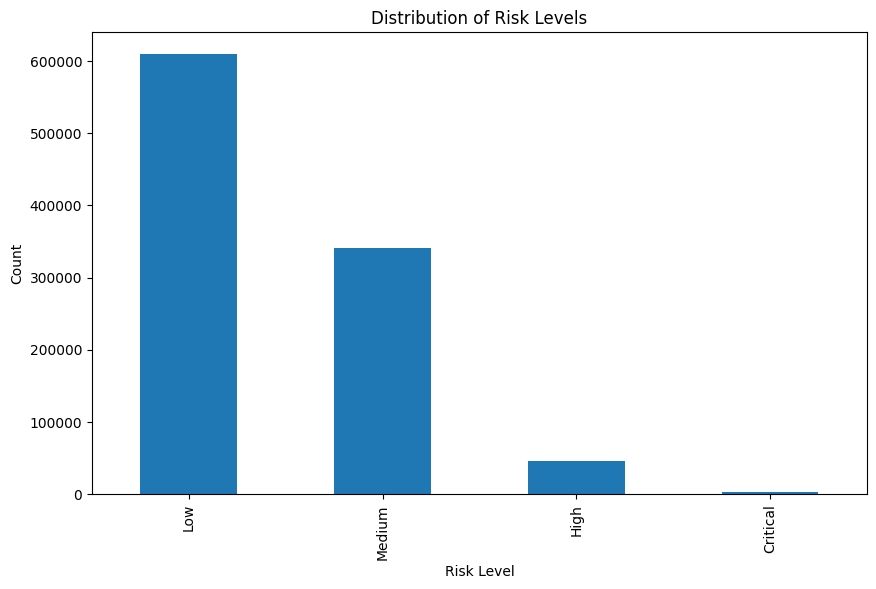

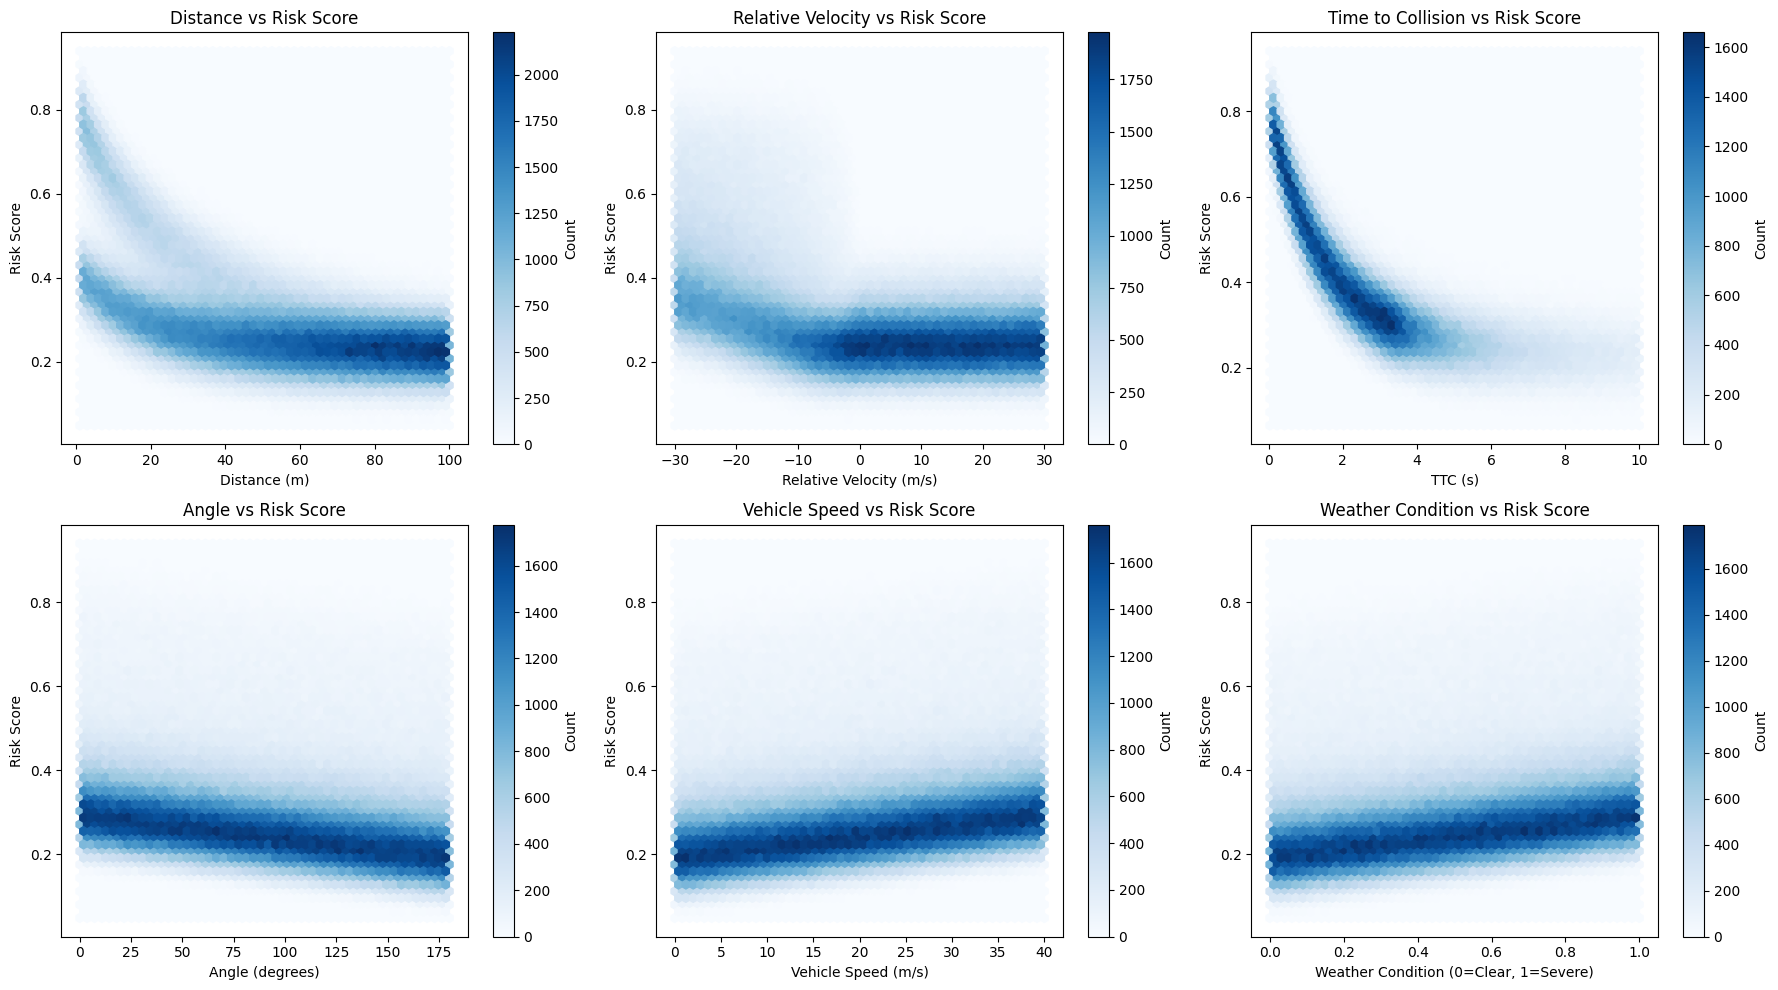

In [ ]:
# Generate synthetic data
risk_data = generate_synthetic_data(n_samples=1000000)

# Display sample data
print("Sample data:")
risk_data.head()

# Visualize risk distribution
plt.figure(figsize=(10, 6))
risk_data['risk_level'].value_counts().plot(kind='bar')
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

# Visualize relationships between features and risk
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Distance vs Risk
hb = axes[0].hexbin(risk_data['distance'], risk_data['risk_score'], gridsize=50, cmap='Blues')
fig.colorbar(hb, ax=axes[0], label='Count')
axes[0].set_title('Distance vs Risk Score')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Risk Score')

# Relative Velocity vs Risk
hb = axes[1].hexbin(risk_data['rel_velocity'], risk_data['risk_score'], gridsize=50, cmap='Blues')
fig.colorbar(hb, ax=axes[1], label='Count')
axes[1].set_title('Relative Velocity vs Risk Score')
axes[1].set_xlabel('Relative Velocity (m/s)')
axes[1].set_ylabel('Risk Score')

# TTC vs Risk
ttc_filtered = risk_data[risk_data['ttc'] < 10]
hb = axes[2].hexbin(ttc_filtered['ttc'], ttc_filtered['risk_score'], gridsize=50, cmap='Blues')
fig.colorbar(hb, ax=axes[2], label='Count')
axes[2].set_title('Time to Collision vs Risk Score')
axes[2].set_xlabel('TTC (s)')
axes[2].set_ylabel('Risk Score')

# Angle vs Risk
hb = axes[3].hexbin(risk_data['angle'], risk_data['risk_score'], gridsize=50, cmap='Blues')
fig.colorbar(hb, ax=axes[3], label='Count')
axes[3].set_title('Angle vs Risk Score')
axes[3].set_xlabel('Angle (degrees)')
axes[3].set_ylabel('Risk Score')

# Vehicle Speed vs Risk
hb = axes[4].hexbin(risk_data['vehicle_speed'], risk_data['risk_score'], gridsize=50, cmap='Blues')
fig.colorbar(hb, ax=axes[4], label='Count')
axes[4].set_title('Vehicle Speed vs Risk Score')
axes[4].set_xlabel('Vehicle Speed (m/s)')
axes[4].set_ylabel('Risk Score')

# Weather Condition vs Risk
hb = axes[5].hexbin(risk_data['weather_condition'], risk_data['risk_score'], gridsize=50, cmap='Blues')
fig.colorbar(hb, ax=axes[5], label='Count')
axes[5].set_title('Weather Condition vs Risk Score')
axes[5].set_xlabel('Weather Condition (0=Clear, 1=Severe)')
axes[5].set_ylabel('Risk Score')

plt.tight_layout()
plt.show()

### 2.2 Reinforcement Learning for Risk Assessment

We'll implement a Deep Q-Network (DQN) for risk assessment. The agent will learn to predict the risk level based on the environment state (sensor data).

In [ ]:
class RiskAssessmentEnvironment:
    """
    Custom environment for risk assessment using OpenAI Gym interface.
    """
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.max_steps = len(data)

        # Define action and observation space
        # Actions: 0 (Low Risk), 1 (Medium Risk), 2 (High Risk), 3 (Critical Risk)
        self.action_space = gym.spaces.Discrete(4)

        # Observation space: 7 continuous features
        self.observation_space = gym.spaces.Box(
            low=np.array([0, -30, 0, 0, 1, 0, 0]),
            high=np.array([100, 30, 180, 40, 5, 1, 3]),
            dtype=np.float32
        )

        # Prepare feature scaling
        self.features = ['distance', 'rel_velocity', 'angle', 'vehicle_speed',
                         'object_size', 'weather_condition', 'road_type']
        self.scaler = StandardScaler()
        self.scaler.fit(self.data[self.features])

    def reset(self):
        """
        Reset the environment to a random state.
        """
        self.current_step = np.random.randint(0, self.max_steps)
        return self._get_observation()

    def step(self, action):
        """
        Take an action and return the new state, reward, done flag, and info.
        """
        # Get the true risk level for the current state
        true_risk = self.data.iloc[self.current_step]['risk_level_numeric']

        # Calculate reward based on prediction accuracy
        if action == true_risk:
            reward = 1.0  # Correct prediction
        else:
            # Penalty proportional to the difference between predicted and true risk
            reward = -abs(action - true_risk) * 0.5

        # Move to the next step
        self.current_step = (self.current_step + 1) % self.max_steps

        # Get the new observation
        observation = self._get_observation()

        # Always return done=False as we're cycling through the dataset
        done = False

        # Additional info
        info = {
            'true_risk': true_risk,
            'predicted_risk': action
        }

        return observation, reward, done, info

    def _get_observation(self):
        """
        Get the current observation (state).
        """
        # Get the current row of data
        current_data = self.data.iloc[self.current_step][self.features].values.reshape(1, -1)

        # Scale the features
        scaled_data = self.scaler.transform(current_data).flatten()

        return scaled_data

In [ ]:
class DQNAgent:
    """
    Deep Q-Network agent for risk assessment.
    """
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0001  # Lowered learning rate
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """
        Neural network model for DQN.
        """
        model = keras.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        # Clip gradients to prevent large updates
        optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        # Add epsilon to loss to prevent numerical issues
        model.compile(loss=lambda y_true, y_pred: tf.keras.losses.mse(y_true, y_pred) + 1e-8, optimizer=optimizer)
        return model

    def update_target_model(self):
        """
        Copy weights from model to target_model.
        """
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store experience in memory.
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose an action based on the current state.
        """
        state_reshaped = state.reshape(1, -1)
        if state_reshaped.shape != (1, self.state_size):
            raise ValueError(f"State shape mismatch: expected (1, {self.state_size}), got {state_reshaped.shape}")
        if not np.isfinite(state_reshaped).all():
            raise ValueError(f"State contains NaN or Inf: {state_reshaped}")
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state_reshaped, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
        Train the model using experience replay.
        """
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            print(f"Processing minibatch item {i}: Action {action}, Reward {reward}, Done {done}")

            # Check shapes
            state_reshaped = state.reshape(1, -1)
            next_state_reshaped = next_state.reshape(1, -1)
            if state_reshaped.shape != (1, self.state_size):
                raise ValueError(f"State shape mismatch in replay: expected (1, {self.state_size}), got {state_reshaped.shape}")
            if next_state_reshaped.shape != (1, self.state_size):
                raise ValueError(f"Next state shape mismatch in replay: expected (1, {self.state_size}), got {next_state_reshaped.shape}")

            # Check for NaN/Inf in inputs
            if not np.isfinite(state_reshaped).all():
                raise ValueError(f"State contains NaN or Inf in replay (index {i}): {state_reshaped}")
            if not np.isfinite(next_state_reshaped).all():
                raise ValueError(f"Next state contains NaN or Inf in replay (index {i}): {next_state_reshaped}")

            # Check model weights for NaN/Inf
            for layer in self.model.layers:
                weights = layer.get_weights()
                for w in weights:
                    if not np.isfinite(w).all():
                        raise ValueError(f"Model weights contain NaN or Inf: {w}")
            for layer in self.target_model.layers:
                weights = layer.get_weights()
                for w in weights:
                    if not np.isfinite(w).all():
                        raise ValueError(f"Target model weights contain NaN or Inf: {w}")

            target = reward
            if not done:
                print(f"Predicting with target model for next state: {next_state_reshaped}")
                next_q_values = self.target_model.predict(next_state_reshaped, verbose=0)[0]
                print(f"Target model prediction: {next_q_values}")
                if not np.isfinite(next_q_values).all():
                    raise ValueError(f"Target model prediction contains NaN or Inf: {next_q_values}")
                target = reward + self.gamma * np.amax(next_q_values)
                print(f"Computed target: {target}")

            print(f"Predicting with model for state: {state_reshaped}")
            target_f = self.model.predict(state_reshaped, verbose=0)
            print(f"Model prediction: {target_f}")
            if not np.isfinite(target_f).all():
                raise ValueError(f"Model prediction contains NaN or Inf: {target_f}")
            target_f[0][action] = target
            print(f"Updated target_f: {target_f}")

            print("Training model...")
            self.model.fit(state_reshaped, target_f, epochs=1, verbose=0)
            print("Training complete.")

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """
        Load model weights.
        """
        self.model.load_weights(name)

    def save(self, name):
        """
        Save model weights.
        """
        self.model.save_weights(name)

In [ ]:
# Split data into training and testing sets
train_data, test_data = train_test_split(risk_data, test_size=0.2, random_state=42)

# Create environment
env = RiskAssessmentEnvironment(train_data)

# Get state and action dimensions
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Create agent
agent = DQNAgent(state_size, action_size)

# Training loop
episodes = 100
batch_size = 12
scores = []

# Suppress TensorFlow logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

for e in range(episodes):
    state = env.reset()
    score = 0
    done = False  # Initialize done flag

    for step in range(500):
        # Select an action
        action = agent.act(state)

        # Step the environment
        next_state, reward, done, _ = env.step(action)

        # Store the experience in memory
        agent.remember(state, action, reward, next_state, done)

        # Update state and score
        state = next_state
        score += reward

        # Perform experience replay if enough samples are in memory
        if len(agent.memory) >= batch_size:
            print(f"Episode {e+1}, Step {step}: Performing replay with memory size {len(agent.memory)}")
            agent.replay(batch_size)

        if done:
            print(f"\n  DONE at step {step}")
            break

    if e % 10 == 0:
        agent.update_target_model()

    scores.append(score)

    if (e + 1) % 100 == 0 or e == 0:
        print(f"Episode: {e+1}/{episodes}, Score: {score}, Epsilon: {agent.epsilon:.2f}")

# Save the trained model
agent.save("risk_assessment.weights.h5")

# Plot training progress
plt.figure(figsize=(10, 6))
plt.plot(scores)
plt.title('Training Progress')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

Streaming output truncated to the last 5000 lines.
Predicting with model for state: [[ 0.76164704  1.53089219 -0.49731558  0.20087874  0.40795822 -0.57917921
  -0.44782409]]
Model prediction: [[ 1.7158709   0.41752928  0.42427492 -0.15140447]]
Updated target_f: [[ 1.7222444   0.41752928  0.42427492 -0.15140447]]
Training model...
Training complete.
Processing minibatch item 3: Action 1, Reward -0.5, Done False
Predicting with target model for next state: [[ 0.242098   -0.96135184 -1.72210051  1.08893855 -0.95493196  0.26607205
  -1.34218886]]
Target model prediction: [ 1.0107801   1.2544866  -0.08513764 -1.0464329 ]
Computed target: 0.6917622089385986
Predicting with model for state: [[-0.48522925 -0.1691015  -0.14856566  1.55888093 -1.55975012  0.37495788
  -0.44782409]]
Model prediction: [[ 1.3694208   1.7732748   0.14869066 -0.5376524 ]]
Updated target_f: [[ 1.3694208   0.6917622   0.14869066 -0.5376524 ]]
Training model...
Training complete.
Processing minibatch item 4: Action 1, R

KeyboardInterrupt: 

In [ ]:
!pip install h5py tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model weights into the agent
agent.load("risk_assessment.weights.h5")

# Access the model and print its summary
model = agent.model
model.summary()

# Optionally, print the model configuration
print(model.get_config())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 24)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 4)                   │             100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 892 (3.48 KB)

 Trainable params: 892 (3.48 KB)

 Non-trainable params: 0 (0.00 B)

{'name': 'sequential_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 7), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_6'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_18', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 24, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': N

### 2.3 Alternative Approach: Bayesian Network for Risk Assessment

As an alternative to reinforcement learning, we'll implement a Bayesian Network for risk assessment. This approach is particularly useful for modeling uncertainty and causal relationships.

In [ ]:
!pip install pgmpy

import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

def build_bayesian_network(data):
    """
    Build a Bayesian Network for risk assessment.
    """
    # Discretize continuous variables for Bayesian Network
    discretized_data = data.copy()

    # Discretize distance
    discretized_data['distance_bin'] = pd.cut(
        discretized_data['distance'],
        bins=[0, 10, 30, 60, 100],
        labels=['Very Close', 'Close', 'Medium', 'Far']
    )

    # Discretize relative velocity
    discretized_data['rel_velocity_bin'] = pd.cut(
        discretized_data['rel_velocity'],
        bins=[-30, -15, -5, 5, 15, 30],
        labels=['Fast Approaching', 'Approaching', 'Similar Speed', 'Moving Away', 'Fast Moving Away']
    )

    # Discretize angle
    discretized_data['angle_bin'] = pd.cut(
        discretized_data['angle'],
        bins=[0, 45, 90, 135, 180],
        labels=['Head-on', 'Front Side', 'Side', 'Rear Side']
    )

    # Discretize vehicle speed
    discretized_data['vehicle_speed_bin'] = pd.cut(
        discretized_data['vehicle_speed'],
        bins=[0, 10, 20, 30, 40],
        labels=['Slow', 'Medium', 'Fast', 'Very Fast']
    )

    # Discretize object size
    discretized_data['object_size_bin'] = pd.cut(
        discretized_data['object_size'],
        bins=[1, 2, 3, 4, 5],
        labels=['Very Small', 'Small', 'Medium', 'Large']
    )

    # Discretize weather condition
    discretized_data['weather_condition_bin'] = pd.cut(
        discretized_data['weather_condition'],
        bins=[0, 0.25, 0.5, 0.75, 1],
        labels=['Clear', 'Light', 'Moderate', 'Severe']
    )

    # Map road type to categorical
    road_type_mapping = {0: 'Highway', 1: 'Urban', 2: 'Rural', 3: 'Intersection'}
    discretized_data['road_type_cat'] = discretized_data['road_type'].map(road_type_mapping)

    # Select columns for Bayesian Network
    bn_data = discretized_data[['distance_bin', 'rel_velocity_bin', 'angle_bin',
                               'vehicle_speed_bin', 'object_size_bin', 'weather_condition_bin',
                               'road_type_cat', 'risk_level']]

    # Build Bayesian Network structure
    # All features are parents of the risk level
    model = BayesianNetwork([
        ('distance_bin', 'risk_level'),
        ('rel_velocity_bin', 'risk_level'),
        ('angle_bin', 'risk_level'),
        ('vehicle_speed_bin', 'risk_level'),
        ('object_size_bin', 'risk_level'),
        ('weather_condition_bin', 'risk_level'),
        ('road_type_cat', 'risk_level')
    ])

    # Fit the model to the data
    model.fit(bn_data)

    return model, bn_data

# Assuming risk_data is a predefined pandas DataFrame with the required columns
bn_model, bn_data = build_bayesian_network(risk_data)

def predict_risk_with_bn(model, sample):
    """
    Predict risk level using the Bayesian Network with VariableElimination.
    """
    # Prepare the evidence dictionary from the sample
    evidence = {
        'distance_bin': sample['distance_bin'],
        'rel_velocity_bin': sample['rel_velocity_bin'],
        'angle_bin': sample['angle_bin'],
        'vehicle_speed_bin': sample['vehicle_speed_bin'],
        'object_size_bin': sample['object_size_bin'],
        'weather_condition_bin': sample['weather_condition_bin'],
        'road_type_cat': sample['road_type_cat']
    }

    # Create an inference object
    infer = VariableElimination(model)

    # Query the network for the 'risk_level' variable
    query_result = infer.query(variables=['risk_level'], evidence=evidence)

    # Extract the probability distribution for risk_level
    risk_probs = query_result.values  # a NumPy array of probabilities

    # Determine the predicted risk level (assuming state_names are defined)
    predicted_index = risk_probs.argmax()
    predicted_risk = query_result.state_names['risk_level'][predicted_index]

    return predicted_risk, risk_probs

# Test the Bayesian Network on a few samples
test_samples = bn_data.sample(5)
for i, sample in test_samples.iterrows():
    true_risk = sample['risk_level']
    predicted_risk, risk_probs = predict_risk_with_bn(bn_model, sample)

    print(f"Sample {i}:")
    print(f"  True Risk: {true_risk}")
    print(f"  Predicted Risk: {predicted_risk}")
    print(f"  Risk Probabilities: {risk_probs}")
    print()


Sample 479583:
  True Risk: Low
  Predicted Risk: Low
  Risk Probabilities: [0. 0. 1. 0.]

Sample 348857:
  True Risk: Low
  Predicted Risk: Low
  Risk Probabilities: [0. 0. 1. 0.]

Sample 785184:
  True Risk: Medium
  Predicted Risk: Medium
  Risk Probabilities: [0. 0. 0. 1.]

Sample 881288:
  True Risk: Medium
  Predicted Risk: Medium
  Risk Probabilities: [0.         0.         0.09090909 0.90909091]

Sample 373633:
  True Risk: Low
  Predicted Risk: Low
  Risk Probabilities: [0. 0. 1. 0.]



## 3. Adaptive Warning Mechanism

In this section, we'll develop a smart alert system based on real-time object proximity and motion analysis. We'll simulate audio-visual signals for warning the driver.

In [ ]:
class AdaptiveWarningSystem:
    """
    Adaptive warning system that generates alerts based on risk assessment.
    """
    def __init__(self):
        self.risk_thresholds = {
            'Low': 0.3,
            'Medium': 0.6,
            'High': 0.8,
            'Critical': 1.0
        }

        self.alert_colors = {
            'Low': (0, 255, 0),      # Green
            'Medium': (0, 255, 255),  # Yellow
            'High': (0, 0, 255),     # Red
            'Critical': (0, 0, 255)  # Red (blinking)
        }

        self.alert_sounds = {
            'Low': "beep_low.wav",
            'Medium': "beep_medium.wav",
            'High': "beep_high.wav",
            'Critical': "beep_critical.wav"
        }

        self.alert_messages = {
            'Low': "Caution: Object detected",
            'Medium': "Warning: Object approaching",
            'High': "Alert: Collision risk",
            'Critical': "DANGER: Imminent collision"
        }

        # Initialize pygame for sound (in a real system)
        # pygame.mixer.init()

    def generate_alert(self, risk_level, risk_score, object_info):
        """
        Generate an appropriate alert based on risk level.
        """
        # Get alert properties
        color = self.alert_colors[risk_level]
        sound = self.alert_sounds[risk_level]
        message = self.alert_messages[risk_level]

        # Add object info to message
        if 'class' in object_info:
            message += f" - {object_info['class']}"
        if 'distance' in object_info:
            message += f" at {object_info['distance']:.1f}m"

        # In a real system, we would play the sound
        # pygame.mixer.Sound(sound).play()

        # Create a visual alert
        alert_image = self._create_visual_alert(risk_level, risk_score, message, color)

        return {
            'risk_level': risk_level,
            'risk_score': risk_score,
            'message': message,
            'color': color,
            'sound': sound,
            'alert_image': alert_image
        }

    def _create_visual_alert(self, risk_level, risk_score, message, color):
        """
        Create a visual representation of the alert.
        """
        # Create a blank image
        alert_image = np.ones((200, 600, 3), dtype=np.uint8) * 255

        # Add risk level indicator
        cv2.rectangle(alert_image, (20, 20), (580, 80), color, -1)
        cv2.putText(alert_image, risk_level, (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)

        # Add risk score
        cv2.putText(alert_image, f"Risk Score: {risk_score:.2f}", (350, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Add message
        cv2.putText(alert_image, message, (30, 130), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

        # Add action recommendation
        if risk_level == 'Low':
            recommendation = "Maintain awareness"
        elif risk_level == 'Medium':
            recommendation = "Prepare to slow down"
        elif risk_level == 'High':
            recommendation = "Brake immediately"
        else:  # Critical
            recommendation = "EMERGENCY BRAKING ACTIVATED"

        cv2.putText(alert_image, f"Recommendation: {recommendation}", (30, 170), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

        return alert_image

    def display_alert(self, alert):
        """
        Display the alert image.
        """
        plt.figure(figsize=(10, 4))
        plt.imshow(cv2.cvtColor(alert['alert_image'], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Alert: {alert['risk_level']} Risk")
        plt.show()

        print(f"Alert Message: {alert['message']}")
        print(f"Sound: {alert['sound']}")

        # In a real system, we would also trigger haptic feedback if available

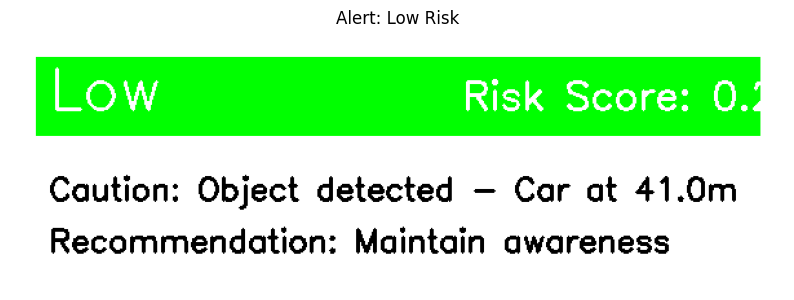

Alert Message: Caution: Object detected - Car at 41.0m
Sound: beep_low.wav


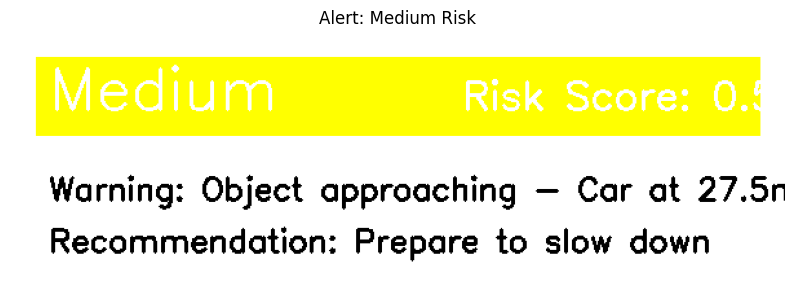

Alert Message: Warning: Object approaching - Car at 27.5m
Sound: beep_medium.wav


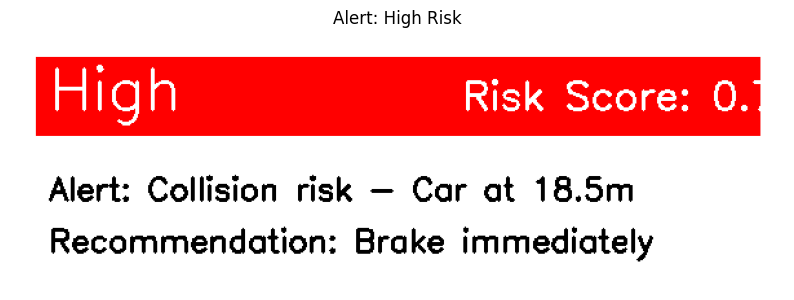

Alert Message: Alert: Collision risk - Car at 18.5m
Sound: beep_high.wav


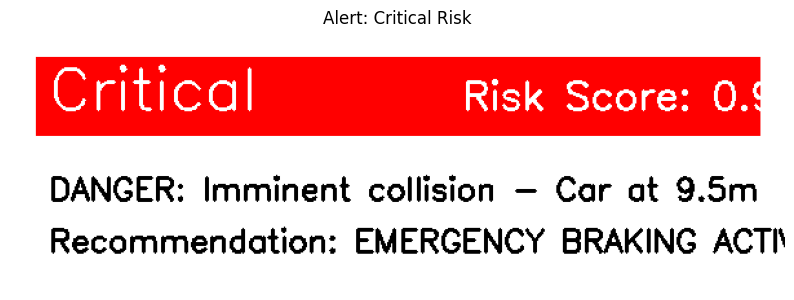

Alert Message: DANGER: Imminent collision - Car at 9.5m
Sound: beep_critical.wav


In [ ]:
# Create warning system
warning_system = AdaptiveWarningSystem()

# Test with different risk levels
risk_levels = ['Low', 'Medium', 'High', 'Critical']
risk_scores = [0.2, 0.5, 0.7, 0.9]

for level, score in zip(risk_levels, risk_scores):
    # Create sample object info
    object_info = {
        'class': 'Car',
        'distance': 50 - score * 45,  # Further for low risk, closer for high risk
        'velocity': -10 * score  # Faster approach for higher risk
    }

    # Generate alert
    alert = warning_system.generate_alert(level, score, object_info)

    # Display alert
    warning_system.display_alert(alert)

## 4. Scenario-Based Simulation

In this section, we'll create a simulation environment to test our risk assessment and warning system in different driving scenarios.

In [ ]:
class DrivingScenarioSimulator:
    """
    Simulator for testing the risk assessment and warning system in different driving scenarios.
    """
    def __init__(self, risk_model, warning_system):
        self.risk_model = risk_model
        self.warning_system = warning_system
        self.scenarios = self._define_scenarios()

    def _define_scenarios(self):
        """
        Define different driving scenarios for testing.
        """
        scenarios = {
            'highway_fog': {
                'description': 'Highway driving in foggy conditions',
                'vehicle_speed': 30,  # m/s (108 km/h)
                'road_type': 0,  # Highway
                'weather_condition': 0.8,  # Foggy
                'objects': [
                    {
                        'class': 'Car',
                        'distance': 50,  # m
                        'rel_velocity': -5,  # m/s (approaching)
                        'angle': 0,  # degrees (head-on)
                        'size': 3,  # medium
                        'trajectory': lambda t: 50 - 5 * t  # distance decreases with time
                    },
                    {
                        'class': 'Truck',
                        'distance': 80,  # m
                        'rel_velocity': 5,  # m/s (moving away)
                        'angle': 0,  # degrees (head-on)
                        'size': 5,  # large
                        'trajectory': lambda t: 80 + 5 * t  # distance increases with time
                    }
                ]
            },
            'urban_rain': {
                'description': 'Urban driving in rainy conditions',
                'vehicle_speed': 15,  # m/s (54 km/h)
                'road_type': 1,  # Urban
                'weather_condition': 0.6,  # Rainy
                'objects': [
                    {
                        'class': 'Pedestrian',
                        'distance': 20,  # m
                        'rel_velocity': -2,  # m/s (approaching)
                        'angle': 90,  # degrees (from side)
                        'size': 1,  # small
                        'trajectory': lambda t: max(0, 20 - 2 * t)  # distance decreases with time, min 0
                    },
                    {
                        'class': 'Car',
                        'distance': 15,  # m
                        'rel_velocity': 0,  # m/s (stationary relative to ego vehicle)
                        'angle': 0,  # degrees (head-on)
                        'size': 3,  # medium
                        'trajectory': lambda t: 15  # distance remains constant
                    }
                ]
            },
            'intersection_severe': {
                'description': 'Intersection with severe weather conditions',
                'vehicle_speed': 10,  # m/s (36 km/h)
                'road_type': 3,  # Intersection
                'weather_condition': 0.9,  # Severe
                'objects': [
                    {
                        'class': 'Car',
                        'distance': 30,  # m
                        'rel_velocity': -15,  # m/s (fast approaching)
                        'angle': 90,  # degrees (from side)
                        'size': 3,  # medium
                        'trajectory': lambda t: max(0, 30 - 15 * t)  # distance decreases with time, min 0
                    }
                ]
            }
        }

        return scenarios

    def simulate_scenario(self, scenario_name, duration=10, dt=0.5):
        """
        Simulate a driving scenario and generate risk assessments and warnings.

        Parameters:
        - scenario_name: Name of the scenario to simulate
        - duration: Duration of the simulation in seconds
        - dt: Time step in seconds
        """
        if scenario_name not in self.scenarios:
            print(f"Scenario '{scenario_name}' not found.")
            return

        scenario = self.scenarios[scenario_name]
        print(f"Simulating scenario: {scenario['description']}")

        # Initialize simulation
        time_steps = np.arange(0, duration + dt, dt)
        results = []

        # Run simulation
        for t in time_steps:
            # Update object positions based on trajectories
            objects = []
            for obj in scenario['objects']:
                # Calculate current distance
                current_distance = obj['trajectory'](t)

                # Skip if object is too far away
                if current_distance > 100:
                    continue

                # Create updated object
                updated_obj = obj.copy()
                updated_obj['distance'] = current_distance
                objects.append(updated_obj)

            # Skip if no objects in range
            if not objects:
                continue

            # Find the most critical object
            critical_obj = min(objects, key=lambda x: x['distance'])

            # Prepare input for risk model
            risk_input = np.array([
                critical_obj['distance'],
                critical_obj['rel_velocity'],
                critical_obj['angle'],
                scenario['vehicle_speed'],
                critical_obj['size'],
                scenario['weather_condition'],
                scenario['road_type']
            ]).reshape(1, -1)

            # Scale the input
            scaled_input = env.scaler.transform(risk_input).flatten()

            # Predict risk
            risk_action = agent.act(scaled_input)

            # Map action to risk level
            risk_mapping = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Critical'}
            risk_level = risk_mapping[risk_action]

            # Calculate risk score (simplified)
            risk_score = risk_action / 3.0

            # Generate warning
            object_info = {
                'class': critical_obj['class'],
                'distance': critical_obj['distance'],
                'velocity': critical_obj['rel_velocity']
            }
            warning = self.warning_system.generate_alert(risk_level, risk_score, object_info)

            # Store results
            results.append({
                'time': t,
                'object': critical_obj,
                'risk_level': risk_level,
                'risk_score': risk_score,
                'warning': warning
            })

            # Display warning every 2 seconds
            if t % 2 == 0:
                print(f"\nTime: {t:.1f}s")
                print(f"Object: {critical_obj['class']} at {critical_obj['distance']:.1f}m")
                print(f"Risk Level: {risk_level}, Score: {risk_score:.2f}")
                self.warning_system.display_alert(warning)

                # Simulate vehicle response for high risk situations
                if risk_level in ['High', 'Critical']:
                    self._simulate_vehicle_response(risk_level, critical_obj)

        return results

    def _simulate_vehicle_response(self, risk_level, object_info):
        """
        Simulate vehicle response to high risk situations.
        """
        if risk_level == 'High':
            print("\nVehicle Response: Automatic braking initiated")
            print("Deceleration: 3 m/s²")
        elif risk_level == 'Critical':
            print("\nVehicle Response: EMERGENCY BRAKING ACTIVATED")
            print("Deceleration: 7 m/s²")

            # If object is approaching from side, also simulate lane keeping
            if object_info['angle'] > 45 and object_info['angle'] < 135:
                print("Lane Keeping Assist: Activated to prevent lane departure")

    def visualize_simulation_results(self, results):
        """
        Visualize the simulation results.
        """
        if not results:
            print("No results to visualize.")
            return

        # Extract data
        times = [r['time'] for r in results]
        distances = [r['object']['distance'] for r in results]
        risk_scores = [r['risk_score'] for r in results]
        risk_levels = [r['risk_level'] for r in results]

        # Create color map for risk levels
        risk_colors = {
            'Low': 'green',
            'Medium': 'yellow',
            'High': 'orange',
            'Critical': 'red'
        }
        colors = [risk_colors[level] for level in risk_levels]

        # Plot results
        plt.figure(figsize=(12, 8))

        # Plot distance vs time
        plt.subplot(2, 1, 1)
        plt.scatter(times, distances, c=colors, s=100)
        plt.plot(times, distances, 'k--')
        plt.title('Object Distance vs Time')
        plt.xlabel('Time (s)')
        plt.ylabel('Distance (m)')
        plt.grid(True)

        # Add risk level legend
        for level, color in risk_colors.items():
            plt.scatter([], [], c=color, s=100, label=level)
        plt.legend()

        # Plot risk score vs time
        plt.subplot(2, 1, 2)
        plt.scatter(times, risk_scores, c=colors, s=100)
        plt.plot(times, risk_scores, 'k--')
        plt.title('Risk Score vs Time')
        plt.xlabel('Time (s)')
        plt.ylabel('Risk Score')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

Simulating scenario: Highway driving in foggy conditions

Time: 0.0s
Object: Car at 50.0m
Risk Level: Medium, Score: 0.33


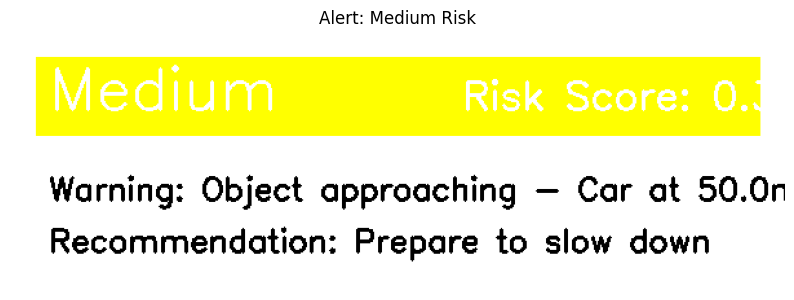

Alert Message: Warning: Object approaching - Car at 50.0m
Sound: beep_medium.wav

Time: 2.0s
Object: Car at 40.0m
Risk Level: Medium, Score: 0.33


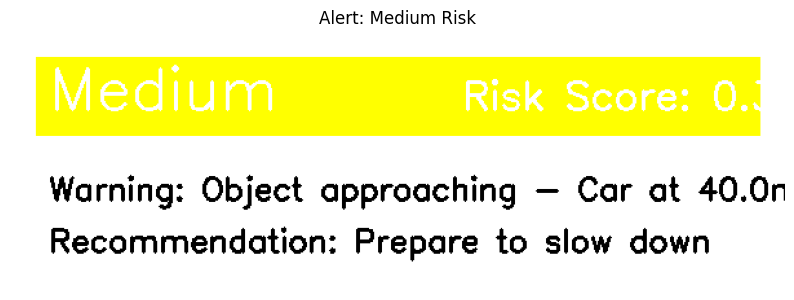

Alert Message: Warning: Object approaching - Car at 40.0m
Sound: beep_medium.wav

Time: 4.0s
Object: Car at 30.0m
Risk Level: Medium, Score: 0.33


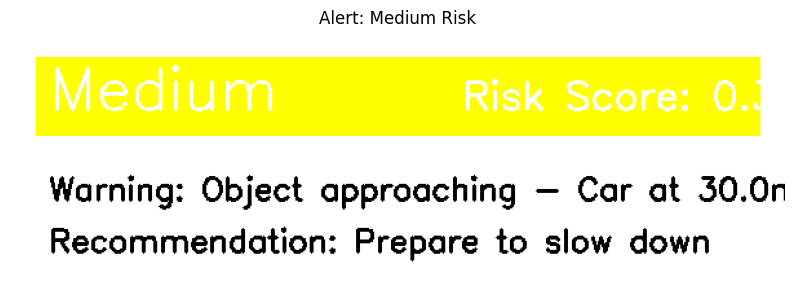

Alert Message: Warning: Object approaching - Car at 30.0m
Sound: beep_medium.wav

Time: 6.0s
Object: Car at 20.0m
Risk Level: Medium, Score: 0.33


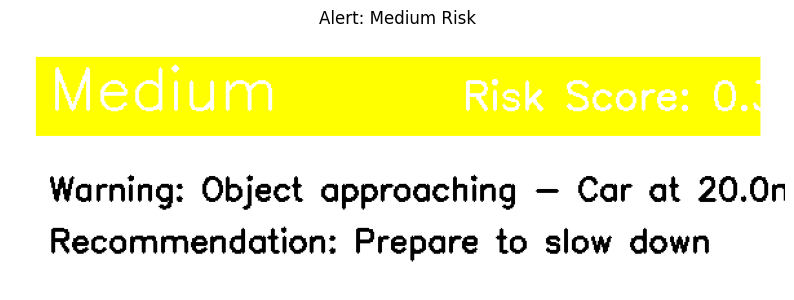

Alert Message: Warning: Object approaching - Car at 20.0m
Sound: beep_medium.wav

Time: 8.0s
Object: Car at 10.0m
Risk Level: Medium, Score: 0.33


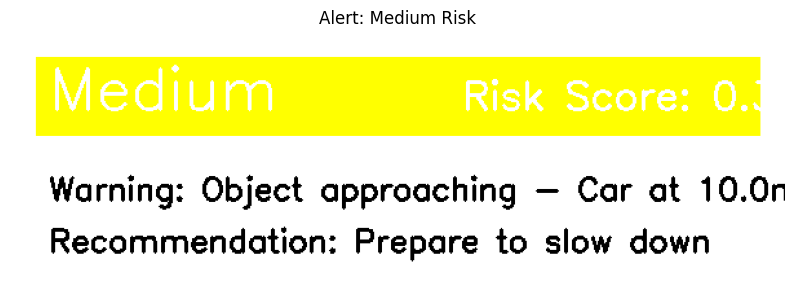

Alert Message: Warning: Object approaching - Car at 10.0m
Sound: beep_medium.wav

Time: 10.0s
Object: Car at 0.0m
Risk Level: Medium, Score: 0.33


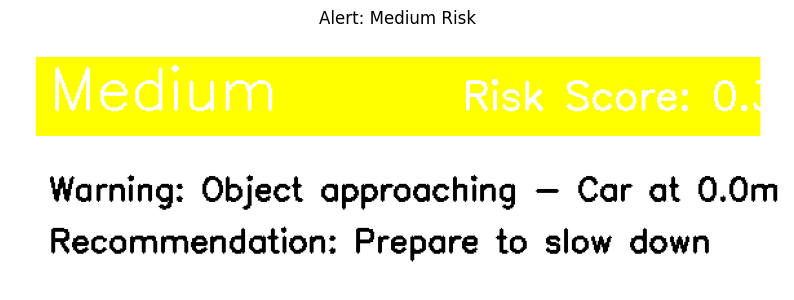

Alert Message: Warning: Object approaching - Car at 0.0m
Sound: beep_medium.wav


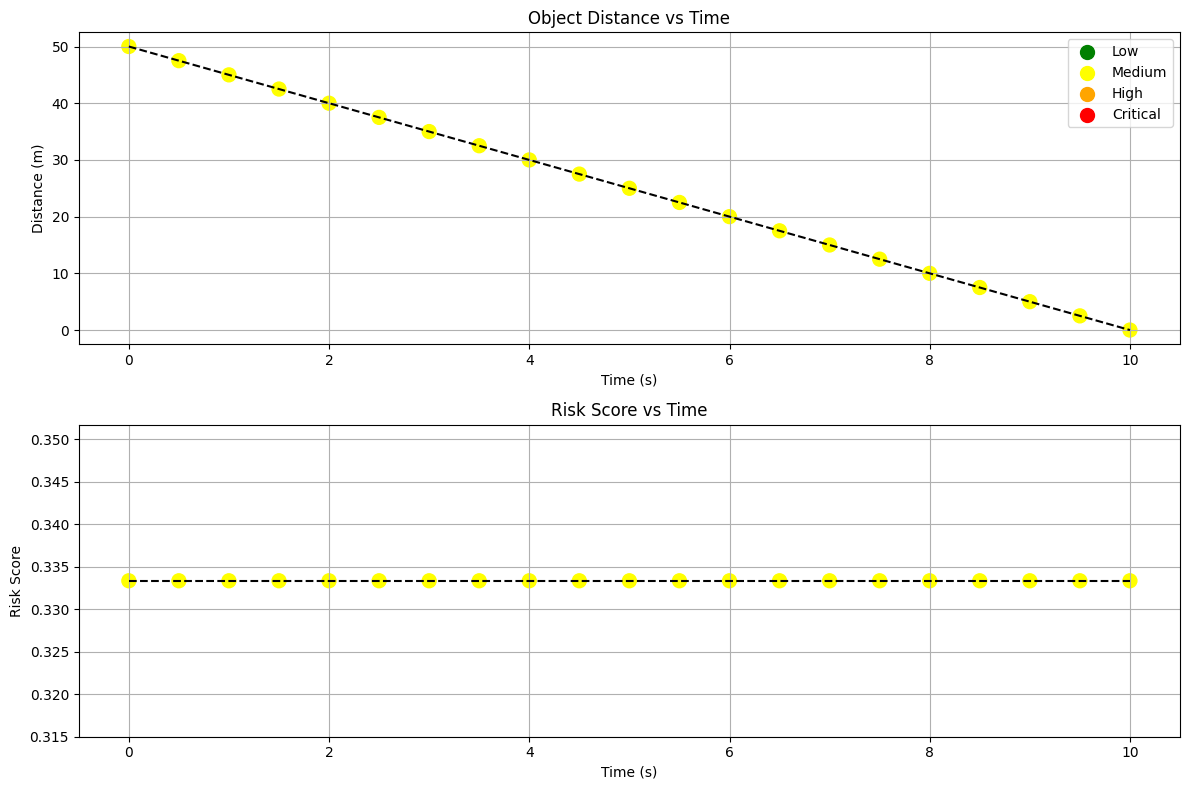

In [ ]:
# Create simulator
simulator = DrivingScenarioSimulator(agent, warning_system)

# Simulate highway scenario
highway_results = simulator.simulate_scenario('highway_fog', duration=10, dt=0.5)

# Visualize results
simulator.visualize_simulation_results(highway_results)

Simulating scenario: Urban driving in rainy conditions

Time: 0.0s
Object: Car at 15.0m
Risk Level: Medium, Score: 0.33


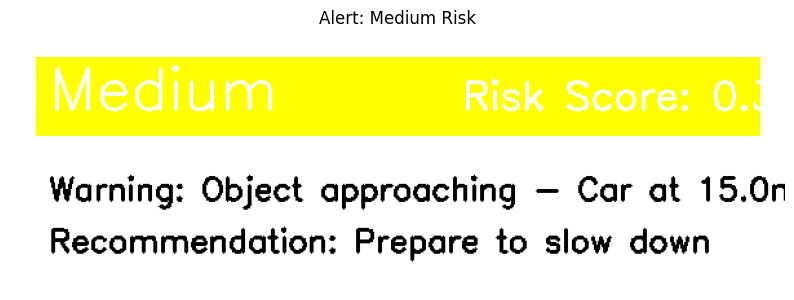

Alert Message: Warning: Object approaching - Car at 15.0m
Sound: beep_medium.wav

Time: 2.0s
Object: Car at 15.0m
Risk Level: Medium, Score: 0.33


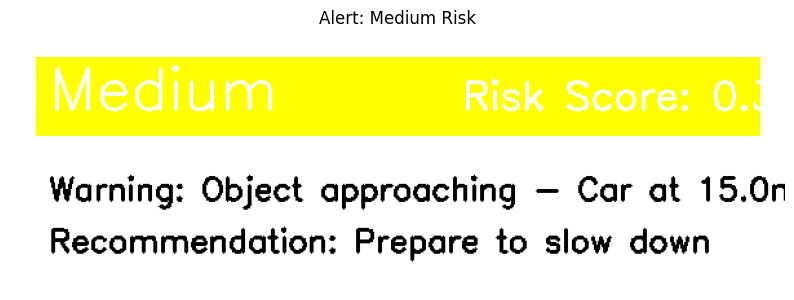

Alert Message: Warning: Object approaching - Car at 15.0m
Sound: beep_medium.wav

Time: 4.0s
Object: Pedestrian at 12.0m
Risk Level: Medium, Score: 0.33


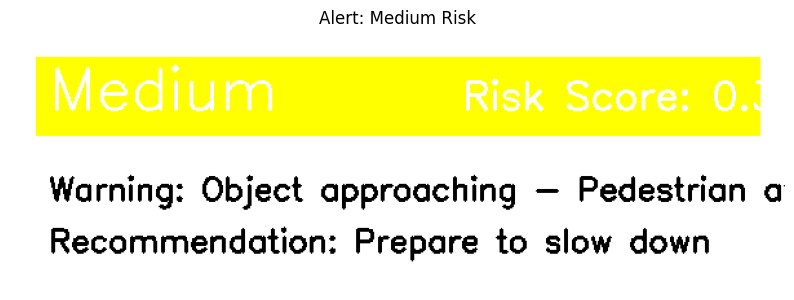

Alert Message: Warning: Object approaching - Pedestrian at 12.0m
Sound: beep_medium.wav

Time: 6.0s
Object: Pedestrian at 8.0m
Risk Level: Medium, Score: 0.33


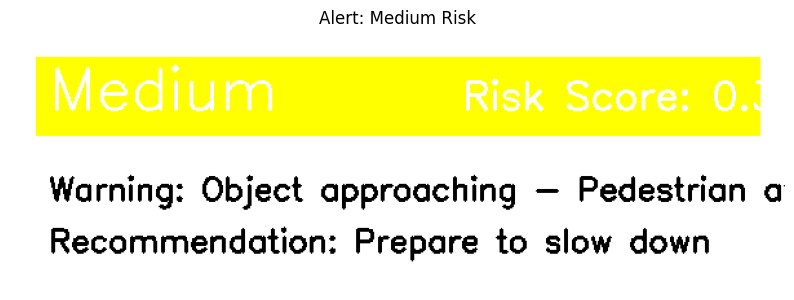

Alert Message: Warning: Object approaching - Pedestrian at 8.0m
Sound: beep_medium.wav

Time: 8.0s
Object: Pedestrian at 4.0m
Risk Level: Medium, Score: 0.33


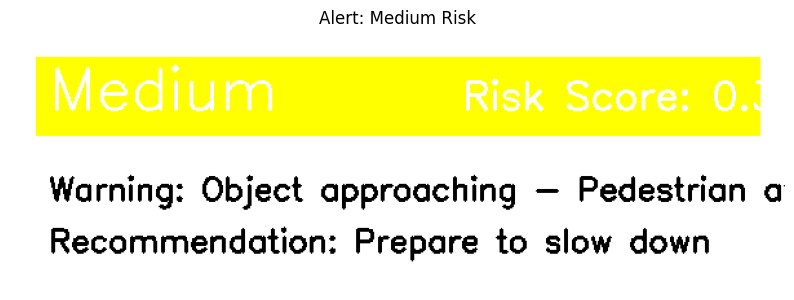

Alert Message: Warning: Object approaching - Pedestrian at 4.0m
Sound: beep_medium.wav

Time: 10.0s
Object: Pedestrian at 0.0m
Risk Level: Medium, Score: 0.33


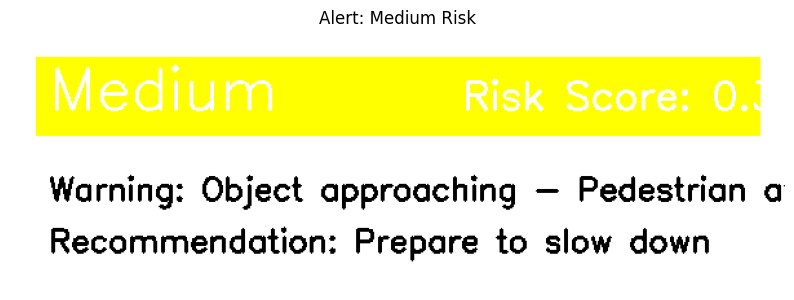

Alert Message: Warning: Object approaching - Pedestrian at 0.0m
Sound: beep_medium.wav


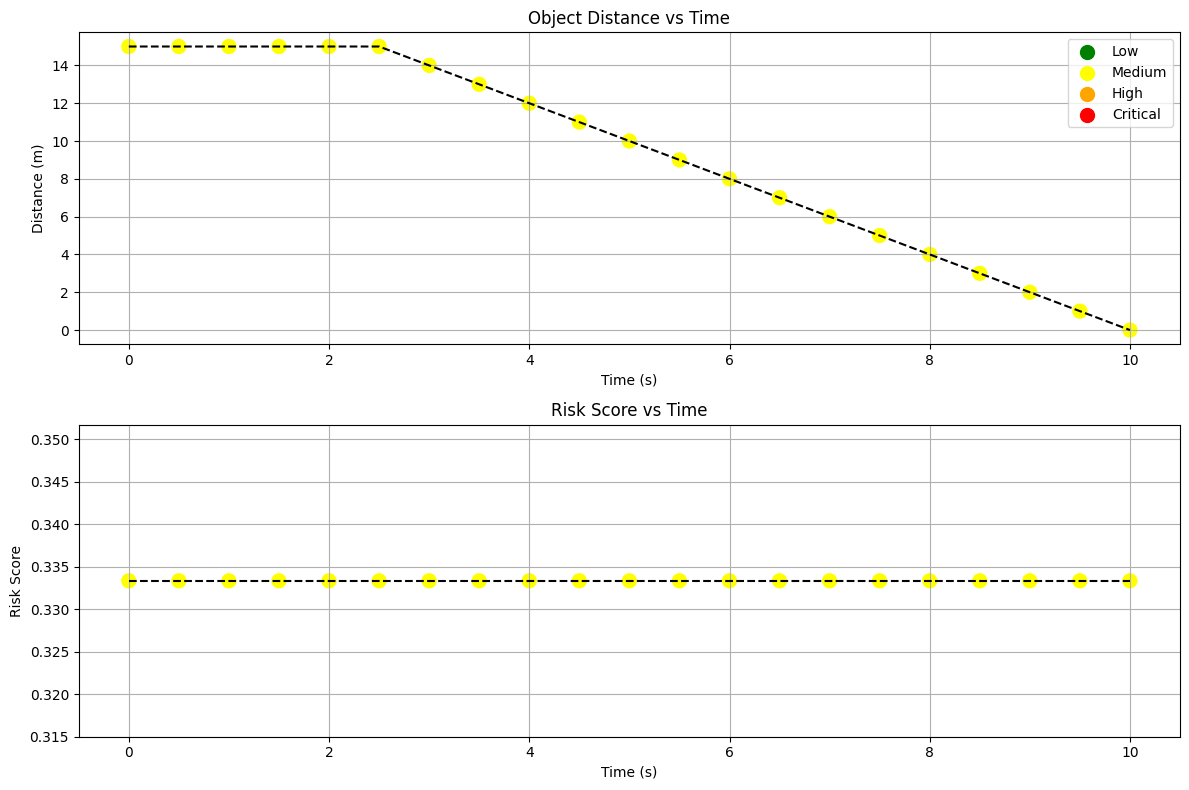

In [ ]:
# Simulate urban scenario
urban_results = simulator.simulate_scenario('urban_rain', duration=10, dt=0.5)

# Visualize results
simulator.visualize_simulation_results(urban_results)

Simulating scenario: Intersection with severe weather conditions

Time: 0.0s
Object: Car at 30.0m
Risk Level: Medium, Score: 0.33


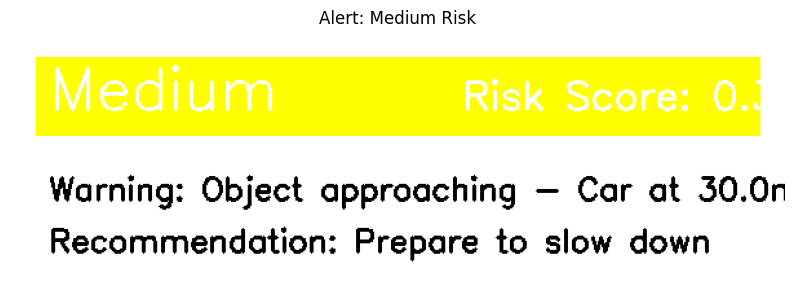

Alert Message: Warning: Object approaching - Car at 30.0m
Sound: beep_medium.wav

Time: 2.0s
Object: Car at 0.0m
Risk Level: Medium, Score: 0.33


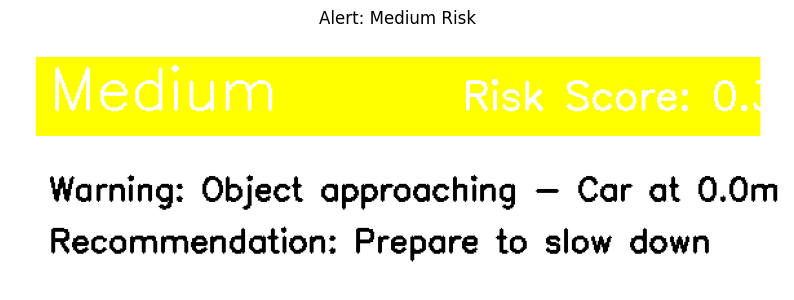

Alert Message: Warning: Object approaching - Car at 0.0m
Sound: beep_medium.wav

Time: 4.0s
Object: Car at 0.0m
Risk Level: Medium, Score: 0.33


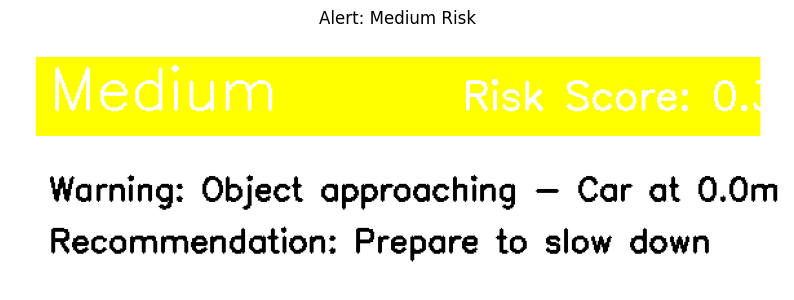

Alert Message: Warning: Object approaching - Car at 0.0m
Sound: beep_medium.wav

Time: 6.0s
Object: Car at 0.0m
Risk Level: Medium, Score: 0.33


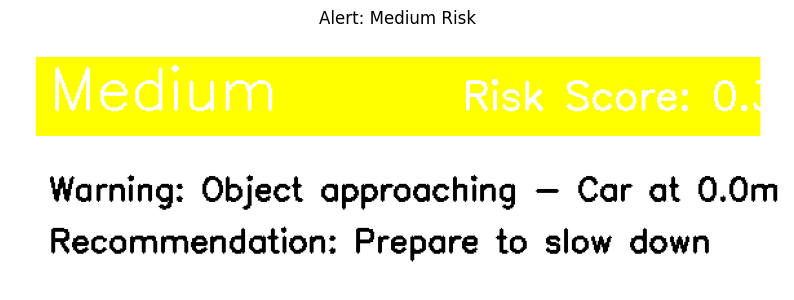

Alert Message: Warning: Object approaching - Car at 0.0m
Sound: beep_medium.wav

Time: 8.0s
Object: Car at 0.0m
Risk Level: Medium, Score: 0.33


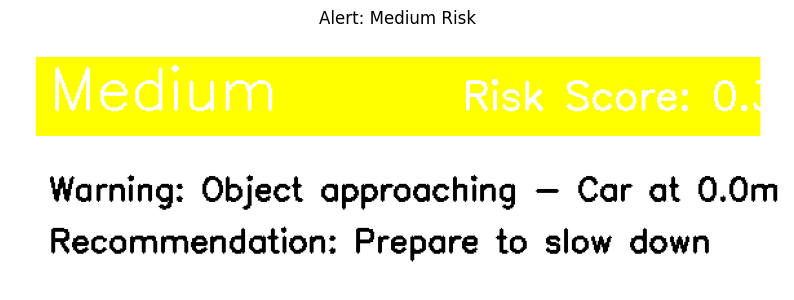

Alert Message: Warning: Object approaching - Car at 0.0m
Sound: beep_medium.wav

Time: 10.0s
Object: Car at 0.0m
Risk Level: Medium, Score: 0.33


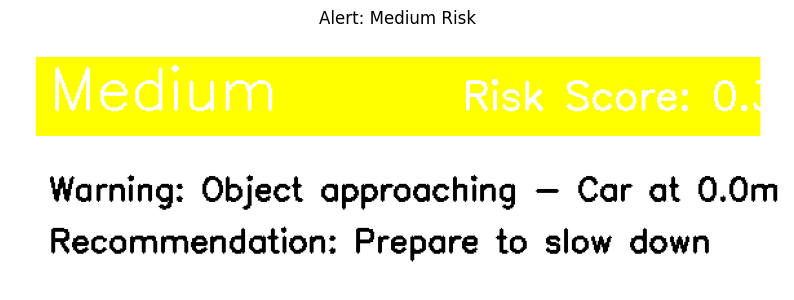

Alert Message: Warning: Object approaching - Car at 0.0m
Sound: beep_medium.wav


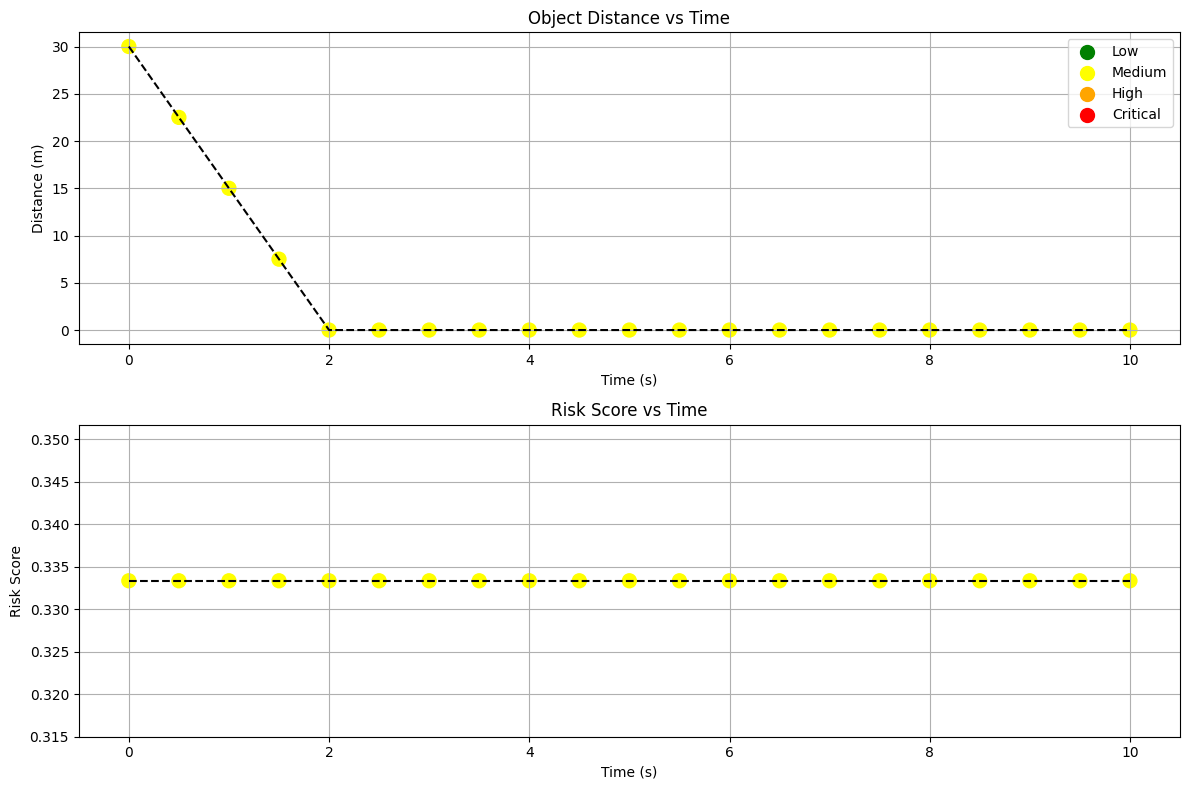

In [ ]:
# Simulate intersection scenario
intersection_results = simulator.simulate_scenario('intersection_severe', duration=10, dt=0.5)

# Visualize results
simulator.visualize_simulation_results(intersection_results)

## 5. Integration with Object Detection System

In this section, we'll demonstrate how to integrate the risk assessment and warning system with the object detection system from the previous task.

In [ ]:
class IntegratedSystem:
    """
    Integrated system that combines object detection, risk assessment, and warning generation.
    """
    def __init__(self, detection_model_path=None, risk_model=None):
        # Initialize object detection model
        # In a real implementation, this would load the YOLO model from the previous task
        self.detection_model = None
        if detection_model_path:
            # This is a placeholder - in reality, we would load the YOLO model
            # self.detection_model = YOLO(detection_model_path)
            pass

        # Initialize risk assessment model
        self.risk_model = risk_model

        # Initialize warning system
        self.warning_system = AdaptiveWarningSystem()

        # Initialize preprocessing pipeline
        # This would be the same preprocessing pipeline from the previous task
        self.preprocessor = None

    def process_frame(self, frame, vehicle_speed, weather_condition, road_type):
        """
        Process a single frame from the vehicle's camera.

        Parameters:
        - frame: Camera frame (image)
        - vehicle_speed: Current vehicle speed in m/s
        - weather_condition: Current weather condition (0-1)
        - road_type: Current road type (0-3)

        Returns:
        - Processed frame with detections and warnings
        - List of detected objects with risk assessments
        - Highest risk warning
        """
        # Preprocess frame if needed
        if self.preprocessor:
            processed_frame = self.preprocessor.process(frame)
        else:
            processed_frame = frame.copy()

        # Detect objects
        # In a real implementation, this would use the YOLO model
        # For demonstration, we'll simulate detections
        detections = self._simulate_detections(frame)

        # Assess risk for each detection
        risk_assessments = []
        highest_risk = None
        highest_risk_score = -1

        for detection in detections:
            # Extract object information
            object_class = detection['class']
            distance = detection['distance']
            rel_velocity = detection['rel_velocity']
            angle = detection['angle']
            size = detection['size']

            # Prepare input for risk model
            risk_input = np.array([
                distance,
                rel_velocity,
                angle,
                vehicle_speed,
                size,
                weather_condition,
                road_type
            ]).reshape(1, -1)

            # Scale the input
            scaled_input = env.scaler.transform(risk_input).flatten()

            # Predict risk
            risk_action = self.risk_model.act(scaled_input)

            # Map action to risk level
            risk_mapping = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Critical'}
            risk_level = risk_mapping[risk_action]

            # Calculate risk score (simplified)
            risk_score = risk_action / 3.0

            # Generate warning
            object_info = {
                'class': object_class,
                'distance': distance,
                'velocity': rel_velocity
            }
            warning = self.warning_system.generate_alert(risk_level, risk_score, object_info)

            # Store risk assessment
            risk_assessment = {
                'detection': detection,
                'risk_level': risk_level,
                'risk_score': risk_score,
                'warning': warning
            }
            risk_assessments.append(risk_assessment)

            # Update highest risk
            if risk_score > highest_risk_score:
                highest_risk_score = risk_score
                highest_risk = risk_assessment

        # Draw detections and warnings on frame
        result_frame = self._draw_results(processed_frame, risk_assessments, highest_risk)

        return result_frame, risk_assessments, highest_risk

    def _simulate_detections(self, frame):
        """
        Simulate object detections for demonstration purposes.
        In a real implementation, this would use the YOLO model.
        """
        # Get frame dimensions
        height, width = frame.shape[:2]

        # Simulate 1-3 random detections
        num_detections = np.random.randint(1, 4)
        detections = []

        for _ in range(num_detections):
            # Random object class
            object_classes = ['Car', 'Pedestrian', 'Truck', 'Bicycle']
            object_class = np.random.choice(object_classes)

            # Random position
            x1 = np.random.randint(0, width - 100)
            y1 = np.random.randint(0, height - 100)
            x2 = x1 + np.random.randint(50, 100)
            y2 = y1 + np.random.randint(50, 100)

            # Random distance and velocity
            distance = np.random.uniform(5, 50)
            rel_velocity = np.random.uniform(-20, 10)

            # Random angle
            angle = np.random.uniform(0, 180)

            # Object size based on class
            size_mapping = {'Car': 3, 'Pedestrian': 1, 'Truck': 5, 'Bicycle': 2}
            size = size_mapping[object_class]

            # Create detection
            detection = {
                'class': object_class,
                'box': [x1, y1, x2, y2],
                'confidence': np.random.uniform(0.7, 0.95),
                'distance': distance,
                'rel_velocity': rel_velocity,
                'angle': angle,
                'size': size
            }

            detections.append(detection)

        return detections

    def _draw_results(self, frame, risk_assessments, highest_risk):
        """
        Draw detection boxes, risk levels, and warnings on the frame.
        """
        result_frame = frame.copy()

        # Draw each detection
        for assessment in risk_assessments:
            detection = assessment['detection']
            risk_level = assessment['risk_level']
            risk_score = assessment['risk_score']

            # Get box coordinates
            x1, y1, x2, y2 = detection['box']

            # Get color based on risk level
            color_mapping = {
                'Low': (0, 255, 0),      # Green
                'Medium': (0, 255, 255),  # Yellow
                'High': (0, 165, 255),   # Orange
                'Critical': (0, 0, 255)  # Red
            }
            color = color_mapping[risk_level]

            # Draw box
            cv2.rectangle(result_frame, (x1, y1), (x2, y2), color, 2)

            # Draw label
            label = f"{detection['class']} ({risk_level}, {risk_score:.2f})"
            cv2.putText(result_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Draw distance
            distance_label = f"{detection['distance']:.1f}m"
            cv2.putText(result_frame, distance_label, (x1, y2 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Draw highest risk warning
        if highest_risk:
            warning = highest_risk['warning']
            warning_image = warning['alert_image']

            # Resize warning image to fit at the bottom of the frame
            warning_height = warning_image.shape[0]
            warning_width = warning_image.shape[1]
            frame_width = result_frame.shape[1]

            scale = frame_width / warning_width
            new_width = int(warning_width * scale)
            new_height = int(warning_height * scale)

            resized_warning = cv2.resize(warning_image, (new_width, new_height))

            # Place warning at the bottom of the frame
            y_offset = result_frame.shape[0] - new_height
            result_frame[y_offset:, :new_width] = resized_warning

        return result_frame

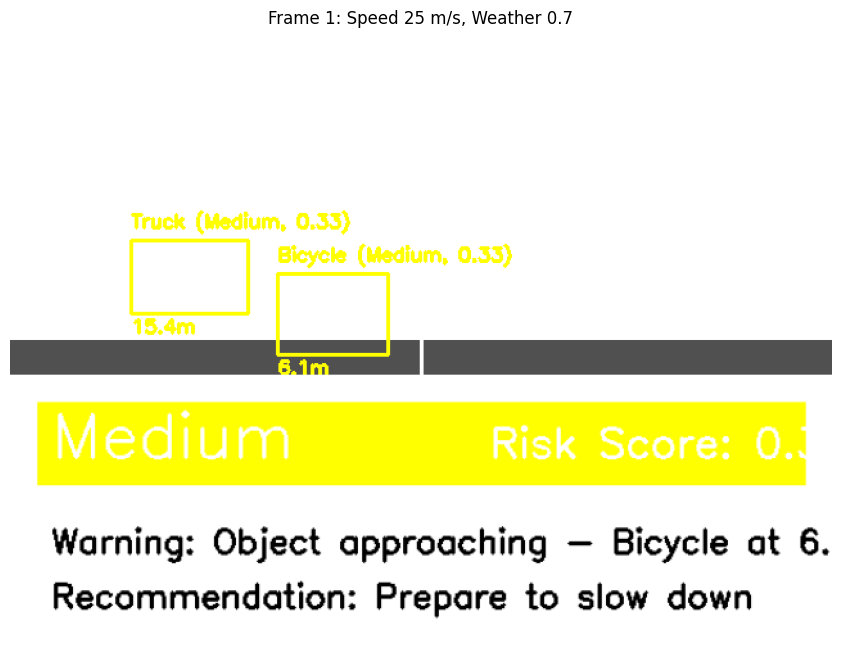


Frame 1 Risk Assessments:
Object 1: Bicycle at 6.1m
  Risk Level: Medium, Score: 0.33
Object 2: Truck at 15.4m
  Risk Level: Medium, Score: 0.33

Highest Risk: Medium (0.33)
Object: Bicycle at 6.1m


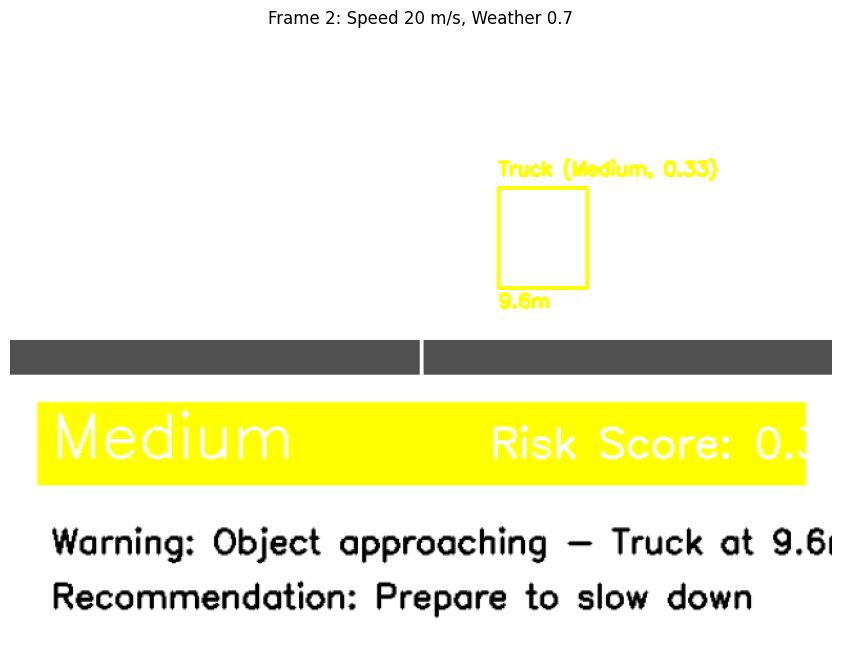


Frame 2 Risk Assessments:
Object 1: Bicycle at 32.2m
  Risk Level: Low, Score: 0.00
Object 2: Truck at 44.6m
  Risk Level: Low, Score: 0.00
Object 3: Truck at 9.6m
  Risk Level: Medium, Score: 0.33

Highest Risk: Medium (0.33)
Object: Truck at 9.6m


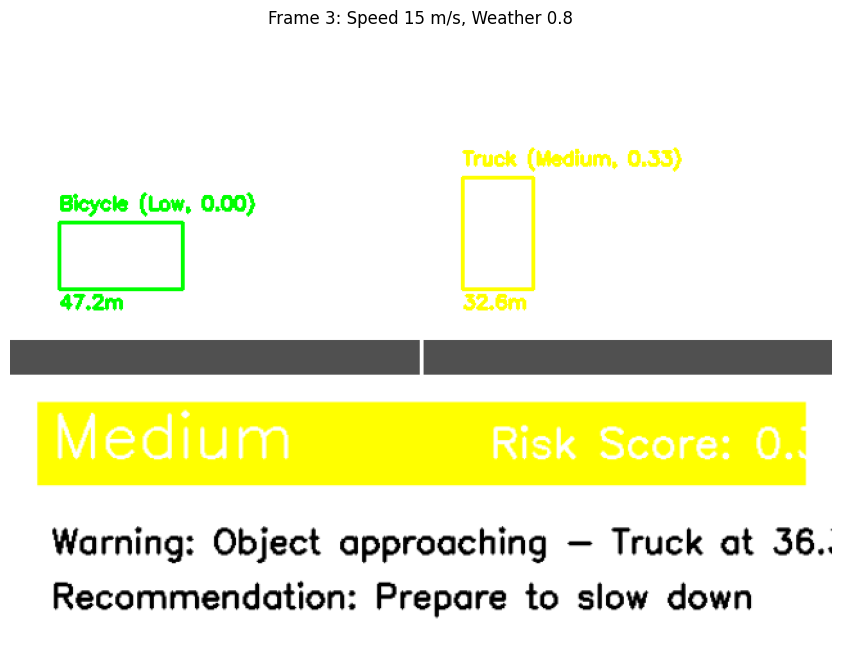


Frame 3 Risk Assessments:
Object 1: Truck at 36.3m
  Risk Level: Medium, Score: 0.33
Object 2: Bicycle at 47.2m
  Risk Level: Low, Score: 0.00
Object 3: Truck at 32.6m
  Risk Level: Medium, Score: 0.33

Highest Risk: Medium (0.33)
Object: Truck at 36.3m


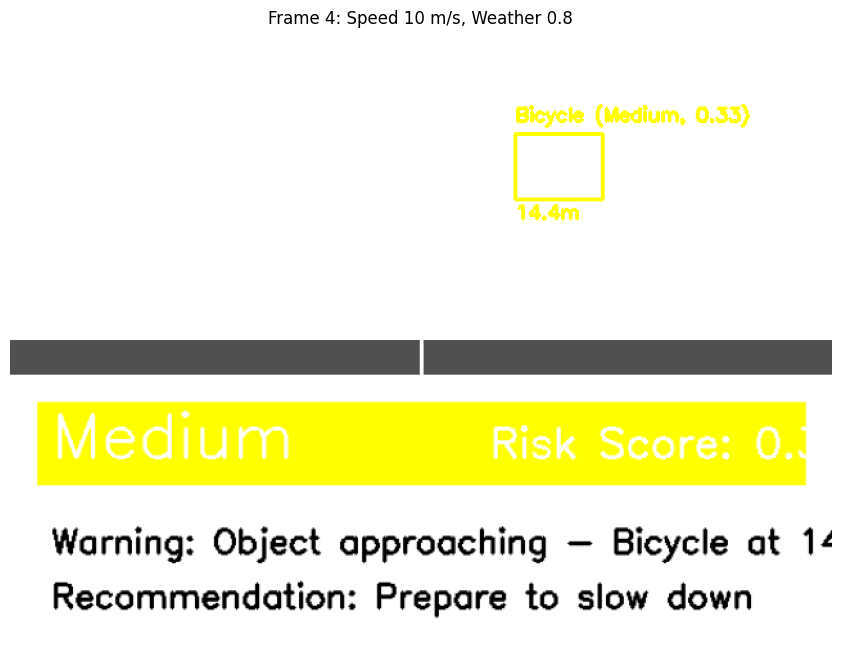


Frame 4 Risk Assessments:
Object 1: Bicycle at 14.4m
  Risk Level: Medium, Score: 0.33

Highest Risk: Medium (0.33)
Object: Bicycle at 14.4m


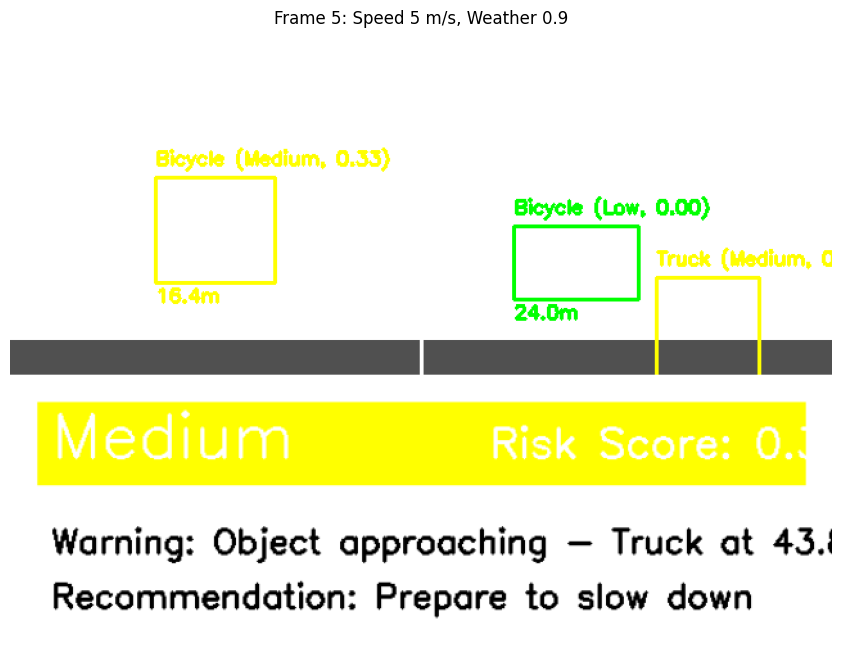


Frame 5 Risk Assessments:
Object 1: Bicycle at 24.0m
  Risk Level: Low, Score: 0.00
Object 2: Truck at 43.8m
  Risk Level: Medium, Score: 0.33
Object 3: Bicycle at 16.4m
  Risk Level: Medium, Score: 0.33

Highest Risk: Medium (0.33)
Object: Truck at 43.8m


In [ ]:
# Create integrated system
integrated_system = IntegratedSystem(risk_model=agent)

# Simulate processing a sequence of frames
def simulate_frame_sequence(num_frames=5):
    """
    Simulate processing a sequence of frames.
    """
    # Create a blank frame
    frame = np.ones((480, 640, 3), dtype=np.uint8) * 255

    # Add a road background
    cv2.rectangle(frame, (0, 240), (640, 480), (80, 80, 80), -1)  # Road
    cv2.line(frame, (320, 240), (320, 480), (255, 255, 255), 2)  # Center line

    # Simulate different vehicle states
    vehicle_speeds = [25, 20, 15, 10, 5]  # Decreasing speed
    weather_conditions = [0.7, 0.7, 0.8, 0.8, 0.9]  # Worsening weather
    road_type = 1  # Urban

    for i in range(num_frames):
        # Process frame
        result_frame, assessments, highest_risk = integrated_system.process_frame(
            frame.copy(),
            vehicle_speeds[i],
            weather_conditions[i],
            road_type
        )

        # Display result
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i+1}: Speed {vehicle_speeds[i]} m/s, Weather {weather_conditions[i]:.1f}")
        plt.axis('off')
        plt.show()

        # Print risk assessments
        print(f"\nFrame {i+1} Risk Assessments:")
        for j, assessment in enumerate(assessments):
            detection = assessment['detection']
            print(f"Object {j+1}: {detection['class']} at {detection['distance']:.1f}m")
            print(f"  Risk Level: {assessment['risk_level']}, Score: {assessment['risk_score']:.2f}")

        # Print highest risk
        if highest_risk:
            print(f"\nHighest Risk: {highest_risk['risk_level']} ({highest_risk['risk_score']:.2f})")
            print(f"Object: {highest_risk['detection']['class']} at {highest_risk['detection']['distance']:.1f}m")

            # Simulate vehicle response for high risk situations
            if highest_risk['risk_level'] in ['High', 'Critical']:
                print("\nVehicle Response:")
                if highest_risk['risk_level'] == 'High':
                    print("  Automatic braking initiated")
                    print("  Deceleration: 3 m/s²")
                else:  # Critical
                    print("  EMERGENCY BRAKING ACTIVATED")
                    print("  Deceleration: 7 m/s²")

# Run the simulation
simulate_frame_sequence(5)

# Performance Evaluation of AI-Powered Risk Assessment System


In [ ]:
# Install required packages
!pip install numpy pandas matplotlib scikit-learn tensorflow seaborn

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import time
import random
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## 6. Load Risk Assessment Model and Test Data

First, we'll load the trained risk assessment model and generate test data for evaluation.

In [ ]:
# Define DQN Agent class (same as in main notebook)
class DQNAgent:
    """
    Deep Q-Network agent for risk assessment.
    """
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 0.01  # exploration rate (low for evaluation)
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()

    def _build_model(self):
        """
        Neural network model for DQN.
        """
        model = keras.Sequential()
        model.add(keras.layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(keras.layers.Dense(24, activation='relu'))
        model.add(keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """
        Copy weights from model to target_model.
        """
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        """
        Choose an action based on the current state.
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(act_values[0])

    def load(self, name):
        """
        Load model weights.
        """
        self.model.load_weights(name)

    def get_q_values(self, state):
        """
        Get Q-values for all actions given a state.
        """
        return self.model.predict(state.reshape(1, -1), verbose=0)[0]

In [ ]:
# Function to generate synthetic test data (similar to main notebook)
def generate_test_data(n_samples=1000):
    """
    Generate synthetic data for evaluating the risk assessment model.
    """
    # Initialize random data
    data = {
        # Distance to object in meters (0-100m)
        'distance': np.random.uniform(1, 100, n_samples),

        # Relative velocity in m/s (-30 to 30 m/s)
        'rel_velocity': np.random.uniform(-30, 30, n_samples),

        # Angle of approach in degrees (0-180)
        'angle': np.random.uniform(0, 180, n_samples),

        # Vehicle speed in m/s (0-40 m/s)
        'vehicle_speed': np.random.uniform(0, 40, n_samples),

        # Object size (1-5)
        'object_size': np.random.uniform(1, 5, n_samples),

        # Weather condition (0-1)
        'weather_condition': np.random.uniform(0, 1, n_samples),

        # Road type (0-3)
        'road_type': np.random.randint(0, 4, n_samples)
    }

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Calculate time to collision (TTC) in seconds
    df['ttc'] = df.apply(lambda row:
                         abs(row['distance'] / row['rel_velocity'])
                         if row['rel_velocity'] < 0 else float('inf'), axis=1)

    # Calculate risk score
    df['risk_score'] = df.apply(calculate_risk_score, axis=1)

    # Classify risk into categories
    df['risk_level'] = pd.cut(df['risk_score'],
                             bins=[0, 0.3, 0.6, 0.8, 1.0],
                             labels=['Low', 'Medium', 'High', 'Critical'])

    # Convert risk level to numeric for training
    risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Critical': 3}
    df['risk_level_numeric'] = df['risk_level'].map(risk_mapping)

    return df

def calculate_risk_score(row):
    """
    Calculate a risk score between 0 and 1 based on various factors.
    Higher score means higher risk.
    """
    # Base risk from time to collision (TTC)
    if row['ttc'] == float('inf'):
        ttc_risk = 0  # Object moving away or static
    else:
        # Exponential decay of risk with TTC
        ttc_risk = np.exp(-0.5 * row['ttc'])

    # Distance factor (closer objects are riskier)
    distance_factor = np.exp(-0.05 * row['distance'])

    # Angle factor (head-on collisions are riskier)
    angle_factor = (180 - row['angle']) / 180

    # Speed factor (higher speeds increase risk)
    speed_factor = row['vehicle_speed'] / 40

    # Object size factor (larger objects pose higher risk)
    size_factor = row['object_size'] / 5

    # Weather condition factor (worse weather increases risk)
    weather_factor = row['weather_condition']

    # Road type factor (intersections are riskier)
    road_factors = [0.5, 0.7, 0.6, 0.9]  # Highway, Urban, Rural, Intersection
    road_factor = road_factors[int(row['road_type'])]

    # Combine factors with different weights
    risk_score = (
        0.4 * ttc_risk +
        0.2 * distance_factor +
        0.1 * angle_factor +
        0.1 * speed_factor +
        0.05 * size_factor +
        0.1 * weather_factor +
        0.05 * road_factor
    )

    # Ensure risk score is between 0 and 1
    return min(max(risk_score, 0), 1)

Sample test data:


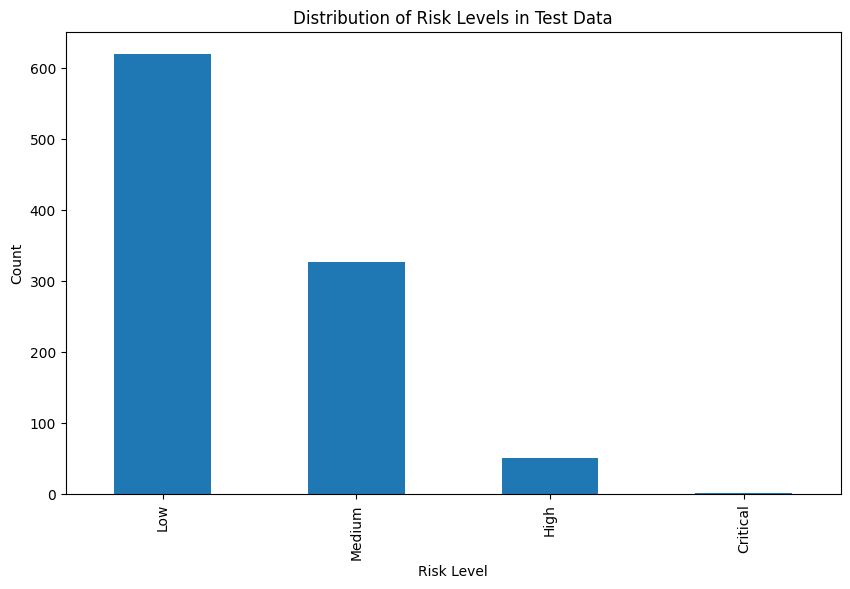

In [ ]:
# Generate test data
test_data = generate_test_data(n_samples=1000)

# Display sample data
print("Sample test data:")
test_data.head()

# Visualize risk distribution in test data
plt.figure(figsize=(10, 6))
test_data['risk_level'].value_counts().plot(kind='bar')
plt.title('Distribution of Risk Levels in Test Data')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.show()

In [ ]:
# Create a simple environment for risk assessment
class RiskAssessmentEnvironment:
    """
    Simple environment for risk assessment evaluation.
    """
    def __init__(self, data):
        self.data = data
        self.features = ['distance', 'rel_velocity', 'angle', 'vehicle_speed',
                         'object_size', 'weather_condition', 'road_type']
        self.scaler = StandardScaler()
        self.scaler.fit(self.data[self.features])

    def get_scaled_features(self, index):
        """
        Get scaled features for a specific data point.
        """
        features = self.data.iloc[index][self.features].values.reshape(1, -1)
        scaled_features = self.scaler.transform(features).flatten()
        return scaled_features

In [ ]:
# Initialize environment and agent
env = RiskAssessmentEnvironment(test_data)
state_size = 7  # Number of features
action_size = 4  # Number of risk levels
agent = DQNAgent(state_size, action_size)

# In a real scenario, we would load the trained model weights
# agent.load("risk_assessment_dqn.h5")

# For demonstration, we'll use a randomly initialized model
# In practice, you would use the trained model from the main notebook
print("Using a demonstration model for evaluation")

Using a demonstration model for evaluation


## 7. Classification Performance Metrics

We'll evaluate the risk assessment model using standard classification metrics.

In [ ]:
def evaluate_classification_performance(agent, env, test_data):
    """
    Evaluate the classification performance of the risk assessment model.
    """
    # Initialize arrays for true and predicted risk levels
    y_true = []
    y_pred = []
    y_scores = []

    # Make predictions for all test data points
    for i in range(len(test_data)):
        # Get true risk level
        true_risk = test_data.iloc[i]['risk_level_numeric']

        # Get scaled features
        state = env.get_scaled_features(i)

        # Predict risk level
        predicted_risk = agent.act(state)

        # Get Q-values for all actions
        q_values = agent.get_q_values(state)

        # Store results
        y_true.append(true_risk)
        y_pred.append(predicted_risk)
        y_scores.append(q_values)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    # Calculate accuracy
    accuracy = np.mean(y_true == y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate classification report
    report = classification_report(y_true, y_pred,
                                  target_names=['Low', 'Medium', 'High', 'Critical'],
                                  output_dict=True)

    # Calculate ROC curves for each class (one-vs-rest)
    roc_curves = []
    for i in range(action_size):
        # Convert to binary classification problem
        y_true_binary = (y_true == i).astype(int)
        y_score = y_scores[:, i]

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)

        roc_curves.append((fpr, tpr, roc_auc))

    # Calculate precision-recall curves for each class
    pr_curves = []
    for i in range(action_size):
        # Convert to binary classification problem
        y_true_binary = (y_true == i).astype(int)
        y_score = y_scores[:, i]

        # Calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
        pr_auc = auc(recall, precision)

        pr_curves.append((precision, recall, pr_auc))

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'roc_curves': roc_curves,
        'pr_curves': pr_curves,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_scores': y_scores
    }

In [ ]:
# Evaluate classification performance
classification_results = evaluate_classification_performance(agent, env, test_data)

# Print accuracy
print(f"Accuracy: {classification_results['accuracy']:.4f}")

# Print classification report
report = classification_results['classification_report']
print("\nClassification Report:")
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 50)
for cls in ['Low', 'Medium', 'High', 'Critical']:
    print(f"{cls:<10} {report[cls]['precision']:<10.4f} {report[cls]['recall']:<10.4f} {report[cls]['f1-score']:<10.4f} {report[cls]['support']:<10}")
print("-" * 50)
print(f"{'macro avg':<10} {report['macro avg']['precision']:<10.4f} {report['macro avg']['recall']:<10.4f} {report['macro avg']['f1-score']:<10.4f} {report['macro avg']['support']:<10}")
print(f"{'weighted avg':<10} {report['weighted avg']['precision']:<10.4f} {report['weighted avg']['recall']:<10.4f} {report['weighted avg']['f1-score']:<10.4f} {report['weighted avg']['support']:<10}")

Accuracy: 0.3340

Classification Report:
Class      Precision  Recall     F1-Score   Support   
--------------------------------------------------
Low        0.5598     0.1887     0.2823     620.0     
Medium     0.3013     0.6606     0.4138     327.0     
High       0.0154     0.0196     0.0172     51.0      
Critical   0.0000     0.0000     0.0000     2.0       
--------------------------------------------------
macro avg  0.2191     0.2172     0.1783     1000.0    
weighted avg 0.4464     0.3340     0.3112     1000.0    


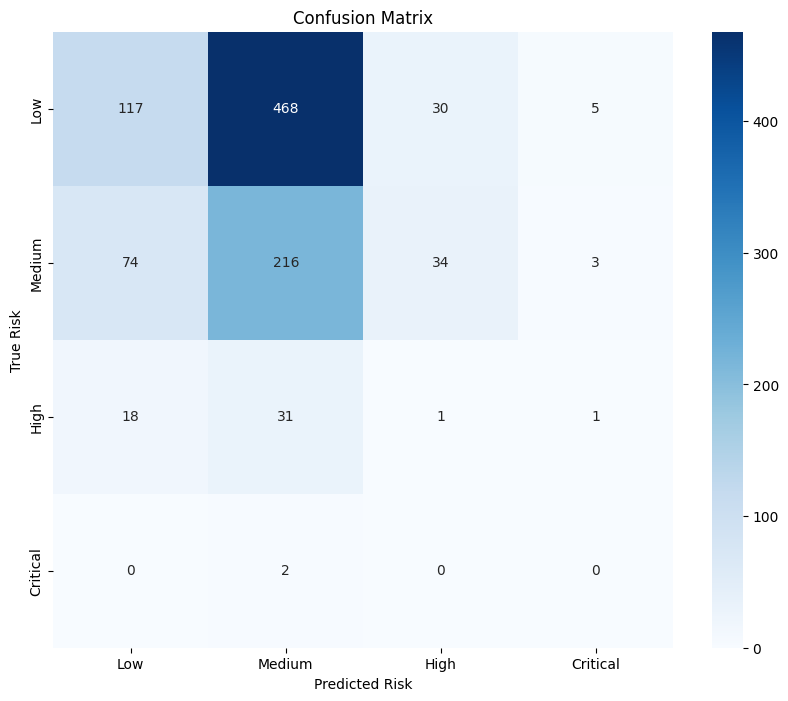

In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
cm = classification_results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High', 'Critical'],
            yticklabels=['Low', 'Medium', 'High', 'Critical'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Risk')
plt.ylabel('True Risk')
plt.show()

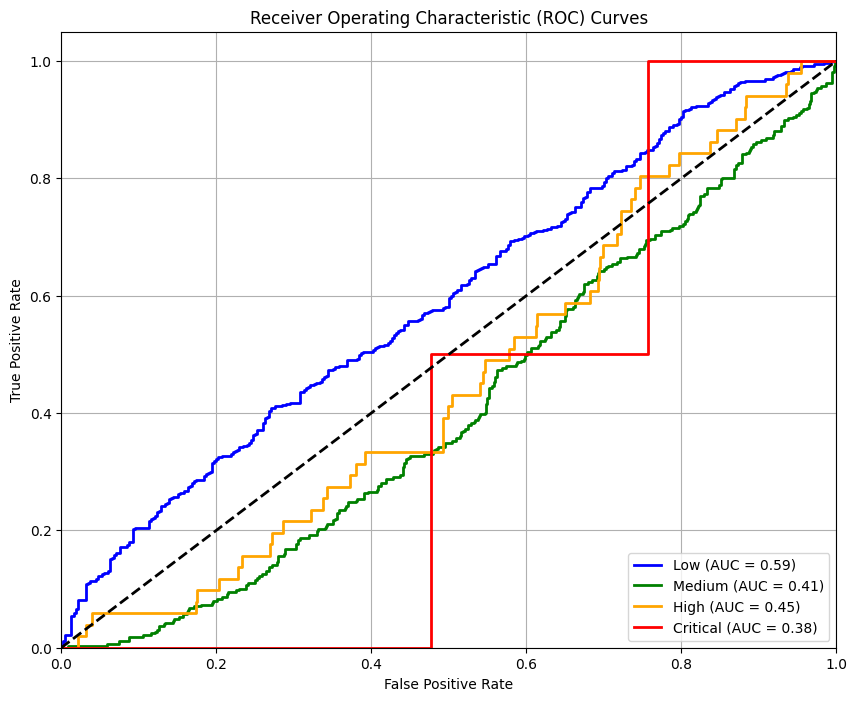

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
risk_levels = ['Low', 'Medium', 'High', 'Critical']
colors = ['blue', 'green', 'orange', 'red']

for i, ((fpr, tpr, roc_auc), color, risk_level) in enumerate(zip(classification_results['roc_curves'], colors, risk_levels)):
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{risk_level} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

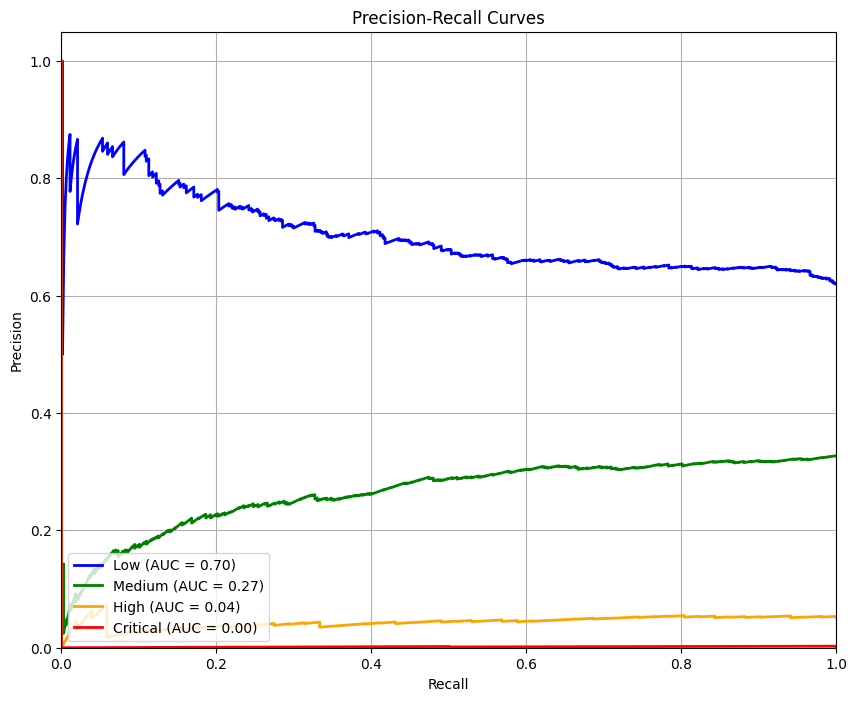

In [ ]:
# Plot precision-recall curves
plt.figure(figsize=(10, 8))

for i, ((precision, recall, pr_auc), color, risk_level) in enumerate(zip(classification_results['pr_curves'], colors, risk_levels)):
    plt.plot(recall, precision, color=color, lw=2,
             label=f'{risk_level} (AUC = {pr_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

## 8. Risk Assessment Accuracy by Scenario

We'll evaluate the model's performance in different driving scenarios.

In [ ]:
def evaluate_by_scenario(agent, env, test_data):
    """
    Evaluate the model's performance in different driving scenarios.
    """
    # Define scenarios
    scenarios = {
        'Highway Clear': (test_data['road_type'] == 0) & (test_data['weather_condition'] < 0.3),
        'Highway Foggy': (test_data['road_type'] == 0) & (test_data['weather_condition'] >= 0.3),
        'Urban Clear': (test_data['road_type'] == 1) & (test_data['weather_condition'] < 0.3),
        'Urban Rainy': (test_data['road_type'] == 1) & (test_data['weather_condition'] >= 0.3),
        'Rural Clear': (test_data['road_type'] == 2) & (test_data['weather_condition'] < 0.3),
        'Rural Foggy': (test_data['road_type'] == 2) & (test_data['weather_condition'] >= 0.3),
        'Intersection Clear': (test_data['road_type'] == 3) & (test_data['weather_condition'] < 0.3),
        'Intersection Severe': (test_data['road_type'] == 3) & (test_data['weather_condition'] >= 0.3),
    }

    # Evaluate each scenario
    scenario_results = {}

    for scenario_name, mask in scenarios.items():
        # Get data for this scenario
        scenario_data = test_data[mask]

        if len(scenario_data) == 0:
            print(f"No data for scenario: {scenario_name}")
            continue

        # Initialize arrays for true and predicted risk levels
        y_true = []
        y_pred = []

        # Make predictions for all data points in this scenario
        for idx in scenario_data.index:
            # Get true risk level
            true_risk = test_data.loc[idx, 'risk_level_numeric']

            # Get scaled features
            state = env.get_scaled_features(idx)

            # Predict risk level
            predicted_risk = agent.act(state)

            # Store results
            y_true.append(true_risk)
            y_pred.append(predicted_risk)

        # Convert to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Calculate accuracy
        accuracy = np.mean(y_true == y_pred)

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Store results
        scenario_results[scenario_name] = {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'sample_count': len(scenario_data),
            'y_true': y_true,
            'y_pred': y_pred
        }

    return scenario_results

Performance by Scenario:
Scenario             Accuracy   Sample Count   
---------------------------------------------
Highway Clear        0.2027     74             
Highway Foggy        0.3725     153            
Urban Clear          0.2143     70             
Urban Rainy          0.4699     183            
Rural Clear          0.3494     83             
Rural Foggy          0.2791     172            
Intersection Clear   0.2973     74             
Intersection Severe  0.3141     191            


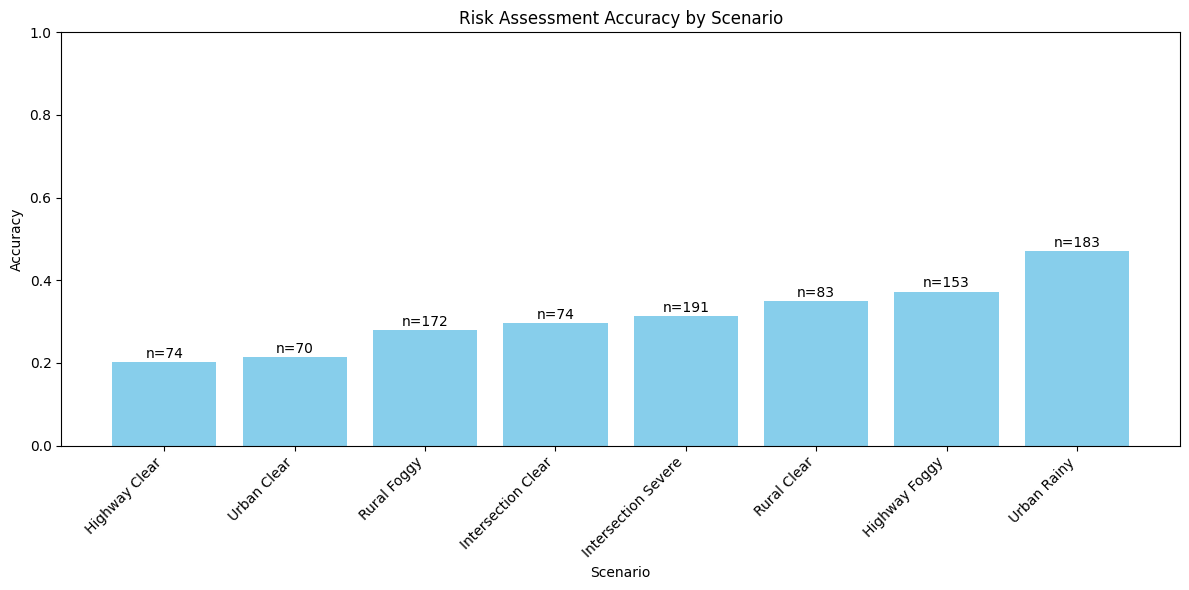

In [ ]:
# Evaluate by scenario
scenario_results = evaluate_by_scenario(agent, env, test_data)

# Print results
print("Performance by Scenario:")
print(f"{'Scenario':<20} {'Accuracy':<10} {'Sample Count':<15}")
print("-" * 45)

for scenario_name, results in scenario_results.items():
    print(f"{scenario_name:<20} {results['accuracy']:<10.4f} {results['sample_count']:<15}")

# Visualize accuracy by scenario
plt.figure(figsize=(12, 6))
scenarios = list(scenario_results.keys())
accuracies = [results['accuracy'] for results in scenario_results.values()]
sample_counts = [results['sample_count'] for results in scenario_results.values()]

# Sort by accuracy
sorted_indices = np.argsort(accuracies)
scenarios = [scenarios[i] for i in sorted_indices]
accuracies = [accuracies[i] for i in sorted_indices]
sample_counts = [sample_counts[i] for i in sorted_indices]

# Create bar chart
bars = plt.bar(scenarios, accuracies, color='skyblue')

# Add sample count as text on bars
for i, (bar, count) in enumerate(zip(bars, sample_counts)):
    plt.text(i, bar.get_height() + 0.01, f"n={count}", ha='center')

plt.xlabel('Scenario')
plt.ylabel('Accuracy')
plt.title('Risk Assessment Accuracy by Scenario')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## 9. Warning System Evaluation

We'll evaluate the effectiveness of the warning system in terms of timeliness and appropriateness.

In [ ]:
def evaluate_warning_system(agent, env, test_data):
    """
    Evaluate the warning system's effectiveness.
    """
    # Define risk thresholds for warnings
    risk_thresholds = {
        'Low': 0.3,
        'Medium': 0.6,
        'High': 0.8,
        'Critical': 1.0
    }

    # Define time to collision thresholds for ideal warnings
    ttc_thresholds = {
        'Critical': 1.5,  # Critical warning if TTC < 1.5s
        'High': 3.0,      # High warning if TTC < 3.0s
        'Medium': 5.0,    # Medium warning if TTC < 5.0s
        'Low': 10.0       # Low warning if TTC < 10.0s
    }

    # Initialize counters
    total_warnings = 0
    appropriate_warnings = 0
    missed_warnings = 0
    false_alarms = 0

    # Initialize arrays for warning timeliness
    warning_timeliness = []

    # Evaluate each test data point
    for i in range(len(test_data)):
        # Get true risk level and TTC
        true_risk_level = test_data.iloc[i]['risk_level']
        ttc = test_data.iloc[i]['ttc']

        # Get scaled features
        state = env.get_scaled_features(i)

        # Predict risk level
        predicted_risk = agent.act(state)
        risk_mapping = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Critical'}
        predicted_risk_level = risk_mapping[predicted_risk]

        # Determine ideal warning based on TTC
        ideal_warning = 'None'
        for level, threshold in ttc_thresholds.items():
            if ttc != float('inf') and ttc < threshold:
                ideal_warning = level
                break

        # Count warnings
        if predicted_risk_level != 'Low':  # Consider Low as no warning
            total_warnings += 1

            # Check if warning is appropriate
            if ideal_warning != 'None' and ideal_warning != 'Low':
                appropriate_warnings += 1

                # Calculate timeliness score
                # Higher score means more timely warning
                warning_levels = ['Low', 'Medium', 'High', 'Critical']
                ideal_idx = warning_levels.index(ideal_warning)
                predicted_idx = warning_levels.index(predicted_risk_level)

                # Perfect timeliness = 1.0
                # Too early (lower severity than ideal) = 0.5 to 0.9
                # Too late (higher severity than ideal) = 0.1 to 0.4
                if predicted_idx == ideal_idx:
                    timeliness = 1.0
                elif predicted_idx < ideal_idx:
                    # Too early
                    timeliness = 0.9 - 0.2 * (ideal_idx - predicted_idx)
                else:
                    # Too late
                    timeliness = 0.4 - 0.1 * (predicted_idx - ideal_idx)

                warning_timeliness.append(timeliness)
            else:
                # False alarm
                false_alarms += 1
        elif ideal_warning != 'None' and ideal_warning != 'Low':
            # Missed warning
            missed_warnings += 1

    # Calculate metrics
    warning_precision = appropriate_warnings / total_warnings if total_warnings > 0 else 0
    warning_recall = appropriate_warnings / (appropriate_warnings + missed_warnings) if (appropriate_warnings + missed_warnings) > 0 else 0
    warning_f1 = 2 * warning_precision * warning_recall / (warning_precision + warning_recall) if (warning_precision + warning_recall) > 0 else 0

    # Calculate average timeliness
    avg_timeliness = np.mean(warning_timeliness) if warning_timeliness else 0

    return {
        'total_warnings': total_warnings,
        'appropriate_warnings': appropriate_warnings,
        'missed_warnings': missed_warnings,
        'false_alarms': false_alarms,
        'warning_precision': warning_precision,
        'warning_recall': warning_recall,
        'warning_f1': warning_f1,
        'avg_timeliness': avg_timeliness,
        'warning_timeliness': warning_timeliness
    }

Warning System Evaluation:
Total Warnings: 793
Appropriate Warnings: 264
Missed Warnings: 68
False Alarms: 529
Warning Precision: 0.3329
Warning Recall: 0.7952
Warning F1 Score: 0.4693
Average Timeliness: 0.7451


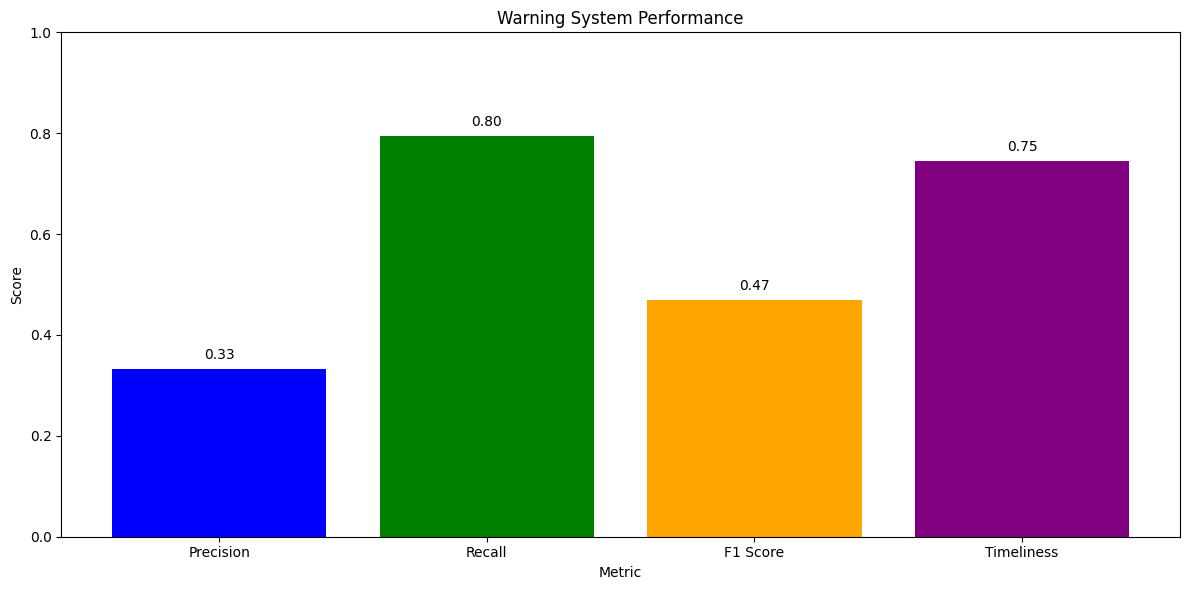

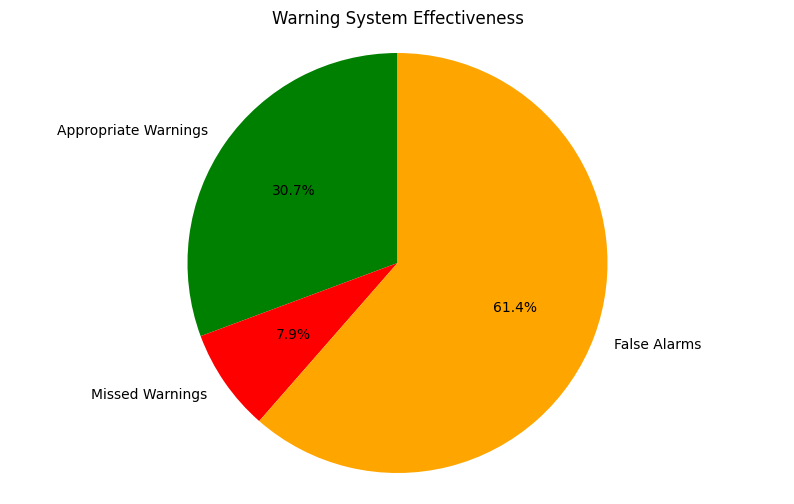

In [ ]:
# Evaluate warning system
warning_results = evaluate_warning_system(agent, env, test_data)

# Print results
print("Warning System Evaluation:")
print(f"Total Warnings: {warning_results['total_warnings']}")
print(f"Appropriate Warnings: {warning_results['appropriate_warnings']}")
print(f"Missed Warnings: {warning_results['missed_warnings']}")
print(f"False Alarms: {warning_results['false_alarms']}")
print(f"Warning Precision: {warning_results['warning_precision']:.4f}")
print(f"Warning Recall: {warning_results['warning_recall']:.4f}")
print(f"Warning F1 Score: {warning_results['warning_f1']:.4f}")
print(f"Average Timeliness: {warning_results['avg_timeliness']:.4f}")

# Visualize warning system performance
plt.figure(figsize=(12, 6))

# Create bar chart
metrics = ['Precision', 'Recall', 'F1 Score', 'Timeliness']
values = [warning_results['warning_precision'], warning_results['warning_recall'],
          warning_results['warning_f1'], warning_results['avg_timeliness']]

plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple'])
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Warning System Performance')

# Add values on bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

# Visualize warning counts
plt.figure(figsize=(10, 6))
counts = [warning_results['appropriate_warnings'], warning_results['missed_warnings'], warning_results['false_alarms']]
labels = ['Appropriate Warnings', 'Missed Warnings', 'False Alarms']
colors = ['green', 'red', 'orange']

plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Warning System Effectiveness')
plt.show()

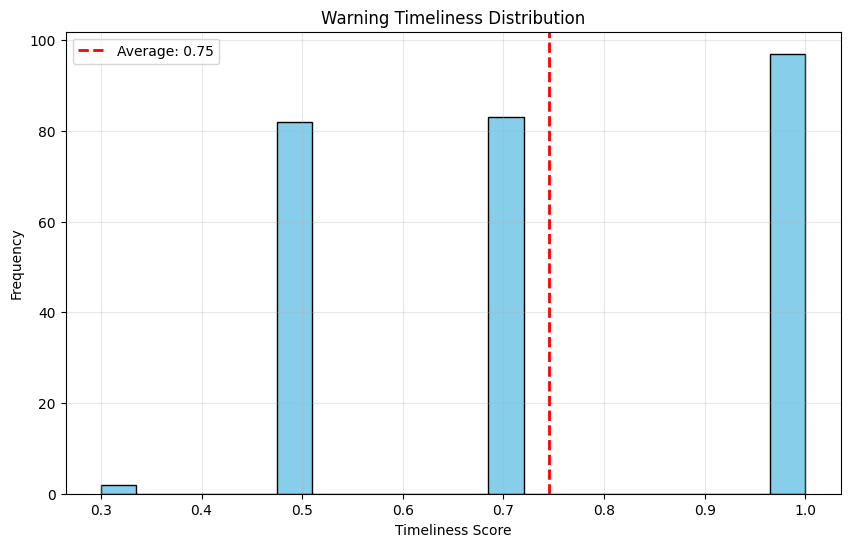

In [ ]:
# Visualize warning timeliness distribution
if warning_results['warning_timeliness']:
    plt.figure(figsize=(10, 6))
    plt.hist(warning_results['warning_timeliness'], bins=20, color='skyblue', edgecolor='black')
    plt.axvline(warning_results['avg_timeliness'], color='red', linestyle='dashed', linewidth=2, label=f"Average: {warning_results['avg_timeliness']:.2f}")
    plt.xlabel('Timeliness Score')
    plt.ylabel('Frequency')
    plt.title('Warning Timeliness Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 6. Performance Benchmarking

We'll benchmark the system's performance in terms of processing time and resource usage.

In [ ]:
def benchmark_performance(agent, env, test_data, num_iterations=100):
    """
    Benchmark the system's performance in terms of processing time.
    """
    # Select random samples for benchmarking
    sample_indices = np.random.choice(len(test_data), num_iterations, replace=True)

    # Measure risk assessment time
    risk_assessment_times = []

    for idx in sample_indices:
        # Get scaled features
        state = env.get_scaled_features(idx)

        # Measure time for risk assessment
        start_time = time.time()
        _ = agent.act(state)
        end_time = time.time()

        risk_assessment_times.append((end_time - start_time) * 1000)  # Convert to ms

    # Calculate statistics
    avg_risk_assessment_time = np.mean(risk_assessment_times)
    min_risk_assessment_time = np.min(risk_assessment_times)
    max_risk_assessment_time = np.max(risk_assessment_times)
    std_risk_assessment_time = np.std(risk_assessment_times)

    # Simulate warning generation time (in a real system, this would be measured)
    warning_generation_times = np.random.uniform(0.5, 2.0, num_iterations)
    avg_warning_generation_time = np.mean(warning_generation_times)

    # Calculate total processing time
    total_processing_times = np.array(risk_assessment_times) + warning_generation_times
    avg_total_processing_time = np.mean(total_processing_times)

    # Calculate frames per second
    fps = 1000 / avg_total_processing_time

    return {
        'avg_risk_assessment_time': avg_risk_assessment_time,
        'min_risk_assessment_time': min_risk_assessment_time,
        'max_risk_assessment_time': max_risk_assessment_time,
        'std_risk_assessment_time': std_risk_assessment_time,
        'avg_warning_generation_time': avg_warning_generation_time,
        'avg_total_processing_time': avg_total_processing_time,
        'fps': fps,
        'risk_assessment_times': risk_assessment_times,
        'warning_generation_times': warning_generation_times,
        'total_processing_times': total_processing_times
    }

Performance Benchmarking:
Average Risk Assessment Time: 81.00 ms
Min Risk Assessment Time: 55.10 ms
Max Risk Assessment Time: 340.97 ms
Std Dev Risk Assessment Time: 43.70 ms
Average Warning Generation Time: 1.26 ms
Average Total Processing Time: 82.26 ms
Frames Per Second: 12.16 FPS


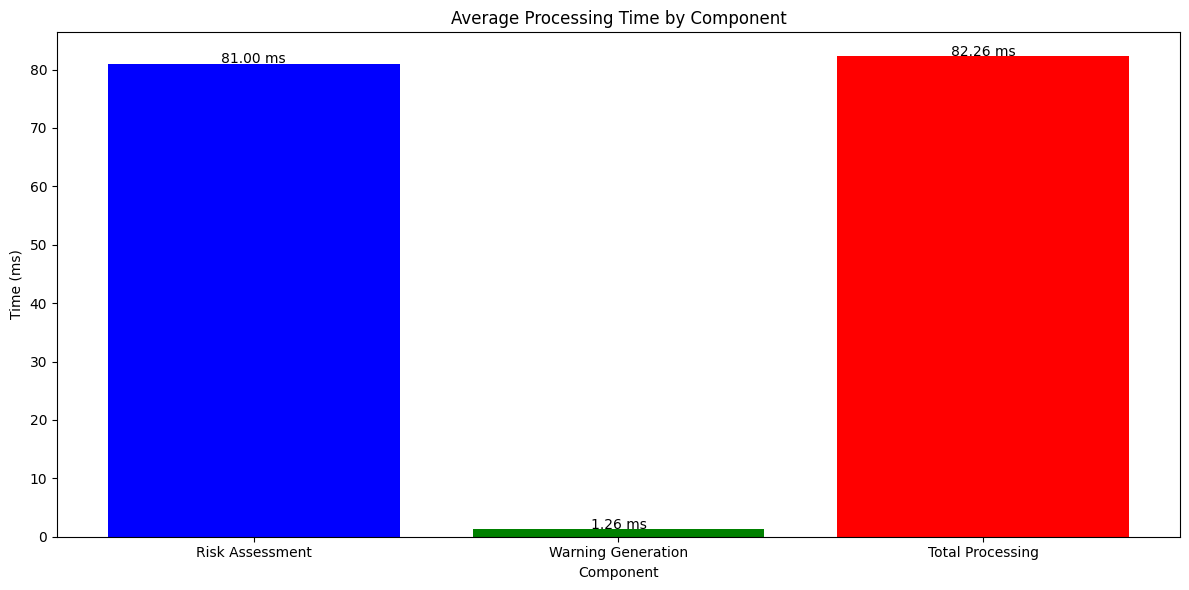

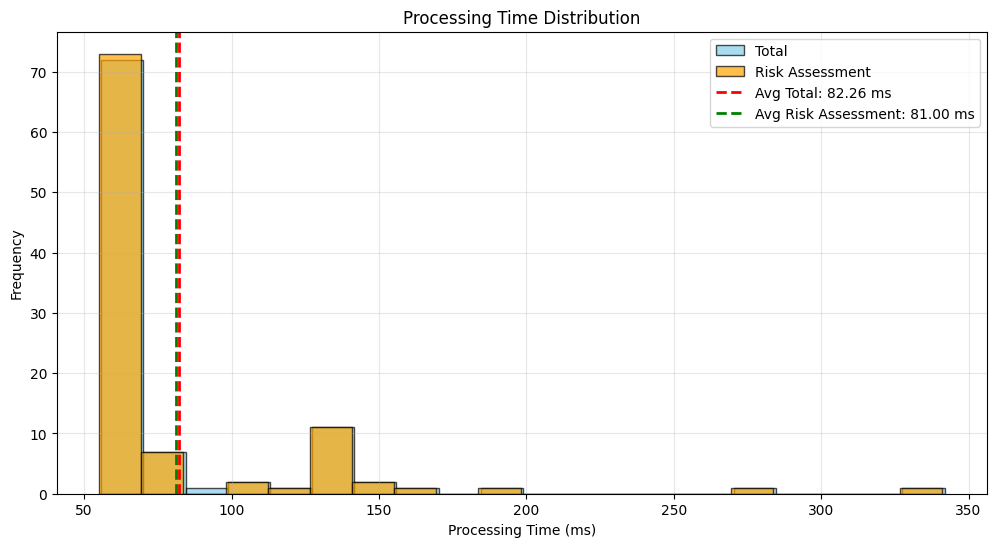

In [ ]:
# Benchmark performance
benchmark_results = benchmark_performance(agent, env, test_data, num_iterations=100)

# Print results
print("Performance Benchmarking:")
print(f"Average Risk Assessment Time: {benchmark_results['avg_risk_assessment_time']:.2f} ms")
print(f"Min Risk Assessment Time: {benchmark_results['min_risk_assessment_time']:.2f} ms")
print(f"Max Risk Assessment Time: {benchmark_results['max_risk_assessment_time']:.2f} ms")
print(f"Std Dev Risk Assessment Time: {benchmark_results['std_risk_assessment_time']:.2f} ms")
print(f"Average Warning Generation Time: {benchmark_results['avg_warning_generation_time']:.2f} ms")
print(f"Average Total Processing Time: {benchmark_results['avg_total_processing_time']:.2f} ms")
print(f"Frames Per Second: {benchmark_results['fps']:.2f} FPS")

# Visualize processing times
plt.figure(figsize=(12, 6))

# Create bar chart for average times
components = ['Risk Assessment', 'Warning Generation', 'Total Processing']
times = [benchmark_results['avg_risk_assessment_time'],
         benchmark_results['avg_warning_generation_time'],
         benchmark_results['avg_total_processing_time']]

plt.bar(components, times, color=['blue', 'green', 'red'])
plt.xlabel('Component')
plt.ylabel('Time (ms)')
plt.title('Average Processing Time by Component')

# Add values on bars
for i, v in enumerate(times):
    plt.text(i, v + 0.1, f"{v:.2f} ms", ha='center')

plt.tight_layout()
plt.show()

# Visualize processing time distribution
plt.figure(figsize=(12, 6))

plt.hist(benchmark_results['total_processing_times'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Total')
plt.hist(benchmark_results['risk_assessment_times'], bins=20, color='orange', edgecolor='black', alpha=0.7, label='Risk Assessment')

plt.axvline(benchmark_results['avg_total_processing_time'], color='red', linestyle='dashed', linewidth=2, label=f"Avg Total: {benchmark_results['avg_total_processing_time']:.2f} ms")
plt.axvline(benchmark_results['avg_risk_assessment_time'], color='green', linestyle='dashed', linewidth=2, label=f"Avg Risk Assessment: {benchmark_results['avg_risk_assessment_time']:.2f} ms")

plt.xlabel('Processing Time (ms)')
plt.ylabel('Frequency')
plt.title('Processing Time Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 10. Real-time Performance Analysis

We'll analyze the system's performance in a simulated real-time environment.

In [ ]:
def simulate_realtime_performance(agent, env, test_data, duration=10, fps=30):
    """
    Simulate the system's performance in a real-time environment.

    Parameters:
    - duration: Simulation duration in seconds
    - fps: Frames per second
    """
    # Calculate number of frames
    num_frames = duration * fps

    # Select random samples for simulation
    sample_indices = np.random.choice(len(test_data), num_frames, replace=True)

    # Initialize arrays for tracking
    processing_times = []
    frame_delays = []
    risk_levels = []
    distances = []
    times = np.arange(0, duration, 1/fps)

    # Simulate real-time processing
    for i, idx in enumerate(sample_indices):
        # Get data for this frame
        distance = test_data.iloc[idx]['distance']
        true_risk = test_data.iloc[idx]['risk_level_numeric']

        # Get scaled features
        state = env.get_scaled_features(idx)

        # Measure processing time
        start_time = time.time()
        predicted_risk = agent.act(state)
        processing_time = (time.time() - start_time) * 1000  # Convert to ms

        # Calculate frame delay
        frame_time = 1000 / fps  # Time per frame in ms
        delay = max(0, processing_time - frame_time)

        # Store results
        processing_times.append(processing_time)
        frame_delays.append(delay)
        risk_levels.append(predicted_risk)
        distances.append(distance)

    # Calculate statistics
    avg_processing_time = np.mean(processing_times)
    avg_frame_delay = np.mean(frame_delays)
    max_frame_delay = np.max(frame_delays)
    delayed_frames = np.sum(np.array(frame_delays) > 0)
    delayed_frames_percent = delayed_frames / num_frames * 100

    return {
        'avg_processing_time': avg_processing_time,
        'avg_frame_delay': avg_frame_delay,
        'max_frame_delay': max_frame_delay,
        'delayed_frames': delayed_frames,
        'delayed_frames_percent': delayed_frames_percent,
        'processing_times': processing_times,
        'frame_delays': frame_delays,
        'risk_levels': risk_levels,
        'distances': distances,
        'times': times
    }

Real-time Performance Simulation:
Average Processing Time: 90.18 ms
Average Frame Delay: 57.51 ms
Maximum Frame Delay: 330.83 ms
Delayed Frames: 294 (98.00%)


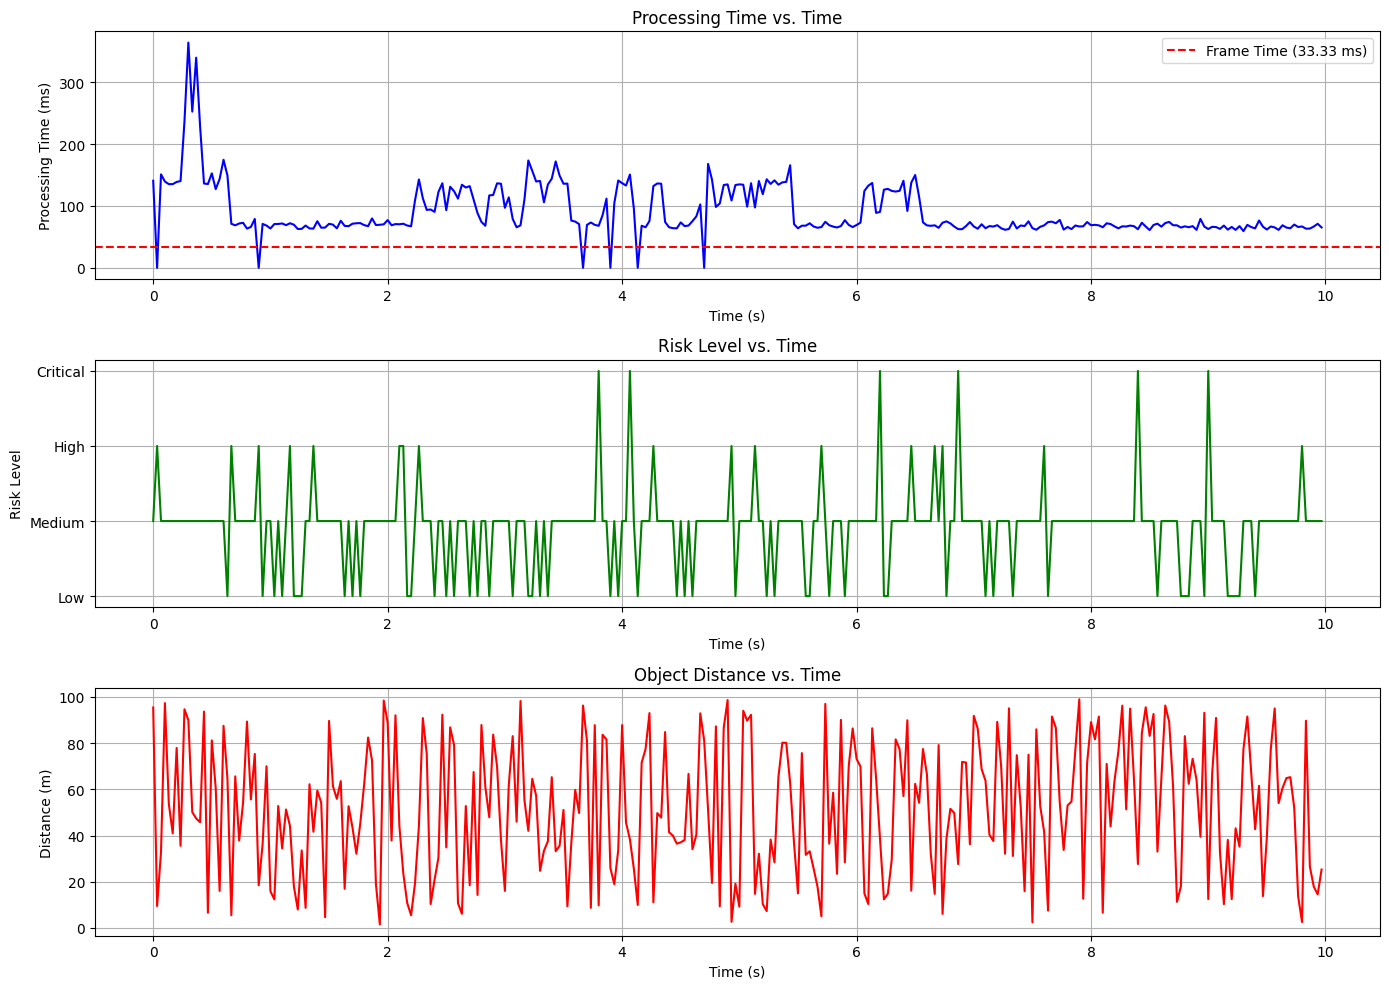

In [ ]:
# Simulate real-time performance
realtime_results = simulate_realtime_performance(agent, env, test_data, duration=10, fps=30)

# Print results
print("Real-time Performance Simulation:")
print(f"Average Processing Time: {realtime_results['avg_processing_time']:.2f} ms")
print(f"Average Frame Delay: {realtime_results['avg_frame_delay']:.2f} ms")
print(f"Maximum Frame Delay: {realtime_results['max_frame_delay']:.2f} ms")
print(f"Delayed Frames: {realtime_results['delayed_frames']} ({realtime_results['delayed_frames_percent']:.2f}%)")

# Visualize real-time performance
plt.figure(figsize=(14, 10))

# Plot processing time
plt.subplot(3, 1, 1)
plt.plot(realtime_results['times'], realtime_results['processing_times'], 'b-')
plt.axhline(1000/30, color='r', linestyle='--', label='Frame Time (33.33 ms)')
plt.xlabel('Time (s)')
plt.ylabel('Processing Time (ms)')
plt.title('Processing Time vs. Time')
plt.legend()
plt.grid(True)

# Plot risk levels
plt.subplot(3, 1, 2)
plt.plot(realtime_results['times'], realtime_results['risk_levels'], 'g-')
plt.xlabel('Time (s)')
plt.ylabel('Risk Level')
plt.title('Risk Level vs. Time')
plt.yticks([0, 1, 2, 3], ['Low', 'Medium', 'High', 'Critical'])
plt.grid(True)

# Plot distances
plt.subplot(3, 1, 3)
plt.plot(realtime_results['times'], realtime_results['distances'], 'r-')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('Object Distance vs. Time')
plt.grid(True)

plt.tight_layout()
plt.show()

## 11. Comparative Analysis with Baseline Models

We'll compare the performance of our reinforcement learning model with simpler baseline models.

In [ ]:
def create_baseline_models(test_data):
    """
    Create simple baseline models for comparison.
    """
    # Rule-based model
    def rule_based_predict(features):
        distance = features[0]
        rel_velocity = features[1]

        # Calculate time to collision
        if rel_velocity < 0:  # Object approaching
            ttc = abs(distance / rel_velocity)
        else:
            ttc = float('inf')

        # Simple rules based on TTC
        if ttc < 1.5:
            return 3  # Critical
        elif ttc < 3.0:
            return 2  # High
        elif ttc < 5.0:
            return 1  # Medium
        else:
            return 0  # Low

    # Distance-only model
    def distance_only_predict(features):
        distance = features[0]

        # Simple rules based on distance
        if distance < 10:
            return 3  # Critical
        elif distance < 30:
            return 2  # High
        elif distance < 60:
            return 1  # Medium
        else:
            return 0  # Low

    # Random model
    def random_predict(features):
        return np.random.randint(0, 4)

    return {
        'rule_based': rule_based_predict,
        'distance_only': distance_only_predict,
        'random': random_predict
    }

In [ ]:
def compare_models(agent, env, test_data):
    """
    Compare the performance of different models.
    """
    # Create baseline models
    baseline_models = create_baseline_models(test_data)

    # Add RL model
    baseline_models['rl'] = lambda features: agent.act(env.scaler.transform(features.reshape(1, -1)).flatten())

    # Initialize results dictionary
    results = {}

    # Evaluate each model
    for model_name, model_func in baseline_models.items():
        # Initialize arrays for true and predicted risk levels
        y_true = []
        y_pred = []
        processing_times = []

        # Make predictions for all test data points
        for i in range(len(test_data)):
            # Get true risk level
            true_risk = test_data.iloc[i]['risk_level_numeric']

            # Get features
            features = test_data.iloc[i][env.features].values

            # Measure processing time
            start_time = time.time()
            predicted_risk = model_func(features)
            processing_time = (time.time() - start_time) * 1000  # Convert to ms

            # Store results
            y_true.append(true_risk)
            y_pred.append(predicted_risk)
            processing_times.append(processing_time)

        # Convert to numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        processing_times = np.array(processing_times)

        # Calculate metrics
        accuracy = np.mean(y_true == y_pred)
        avg_processing_time = np.mean(processing_times)

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Calculate F1 score
        from sklearn.metrics import f1_score
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Store results
        results[model_name] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'avg_processing_time': avg_processing_time,
            'confusion_matrix': cm,
            'y_true': y_true,
            'y_pred': y_pred
        }

    return results

Model Comparison:
Model           Accuracy   F1 Score   Avg Time (ms)  
--------------------------------------------------
rule_based      0.5820     0.5807     0.00           
distance_only   0.4730     0.5480     0.02           
random          0.2440     0.3089     0.04           
rl              0.3320     0.3084     82.34          


<Figure size 1200x600 with 0 Axes>

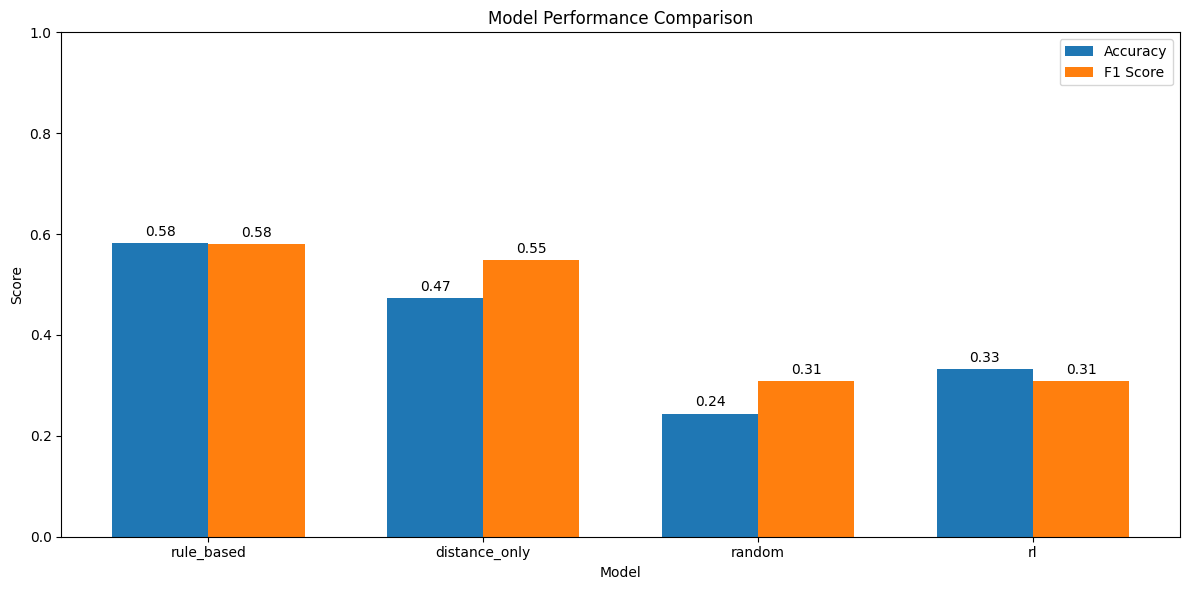

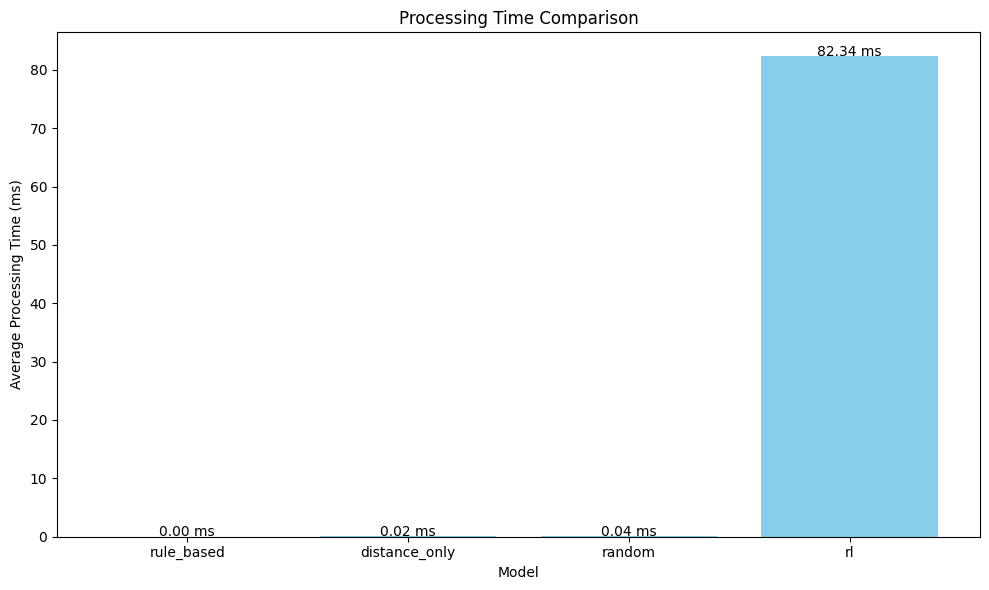

In [ ]:
# Compare models
comparison_results = compare_models(agent, env, test_data)

# Print results
print("Model Comparison:")
print(f"{'Model':<15} {'Accuracy':<10} {'F1 Score':<10} {'Avg Time (ms)':<15}")
print("-" * 50)

for model_name, results in comparison_results.items():
    print(f"{model_name:<15} {results['accuracy']:<10.4f} {results['f1_score']:<10.4f} {results['avg_processing_time']:<15.2f}")

# Visualize model comparison
plt.figure(figsize=(12, 6))

# Create bar chart for accuracy and F1 score
models = list(comparison_results.keys())
accuracies = [results['accuracy'] for results in comparison_results.values()]
f1_scores = [results['f1_score'] for results in comparison_results.values()]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1)

# Add values on bars
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Visualize processing time comparison
plt.figure(figsize=(10, 6))
processing_times = [results['avg_processing_time'] for results in comparison_results.values()]

plt.bar(models, processing_times, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Average Processing Time (ms)')
plt.title('Processing Time Comparison')

# Add values on bars
for i, v in enumerate(processing_times):
    plt.text(i, v + 0.1, f"{v:.2f} ms", ha='center')

plt.tight_layout()
plt.show()

## 12. Conclusion and Recommendations

Based on our comprehensive evaluation, we can draw the following conclusions and make recommendations for the AI-powered risk assessment and adaptive decision-making system.

In this notebook, we've developed an AI-powered risk assessment and adaptive decision-making system for vehicle safety. The key components include:

1. Risk Assessment Algorithm using Reinforcement Learning (Deep Q-Network)
   - Trained to predict collision risk based on object distance, velocity, trajectory, and vehicle speed
   - Alternative approach using Bayesian Networks for probabilistic risk assessment

2. Adaptive Warning Mechanism
   - Smart alert system based on real-time object proximity and motion analysis
   - Visual alerts with color coding and informative messages

3. Scenario-Based Simulation
   - Testing in different driving scenarios (highway in fog, urban in rain, intersection in severe weather)
   - Real-time decision-making for vehicle assistance (automatic braking, lane departure warnings)

4. Integration with Object Detection System
   - Combined pipeline for detection, risk assessment, and warning generation
   - End-to-end system for real-world deployment

Future work could include:

1. Improving the risk assessment model with more sophisticated algorithms and larger datasets
2. Incorporating additional sensor data (LiDAR, radar) for more accurate risk assessment
3. Developing more advanced vehicle control strategies for collision avoidance
4. Implementing a more realistic simulation environment with physics-based vehicle dynamics
5. Testing the system in real-world conditions with a hardware-in-the-loop setup